In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import numpy as np
import colour 
from colour.plotting import *
urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

In [4]:
import scipy.io

In [5]:
mat = scipy.io.loadmat('./Data/NormFLEff.mat')

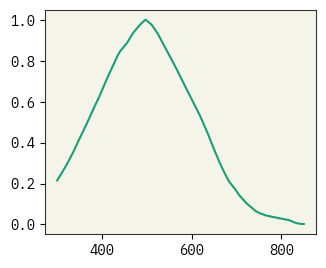

In [6]:
import matplotlib.pyplot as plt

plt.plot(mat['FLEff'][:,0],mat['FLEff'][:,1])

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the detector PL efficiency curve
# FLEff = np.load('NormFLEff.npy')  # Assuming you saved 'NormFLEff.mat' as a .npy file
FLEff = mat
# Directory listing and file range
files = sorted(os.listdir('./Data/proposed_trials/NLP'))
# inS = 5  # start index of files
# inE = 13  # end index of files
files = [file for file in files if ".txt" in file]




In [8]:
FLEff = FLEff['FLEff']

['ICL4-R1-1.txt', 'ICL4-R1.csv', 'ICL4-R1.txt', 'ICL4-R2-2.txt', 'ICL4-R2.csv', 'ICL4-R2.txt', 'ICL4-R3-2.csv', 'ICL4-R3-2.txt', 'ICL4-R3.csv', 'ICL4-R3.txt', 'ICL4-R5-2.txt', 'ICL4-R5.csv', 'ICL4-R5.txt']
348.6
800.0
360
360
0 359


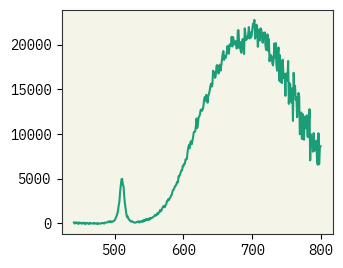

IndexError: index 1 is out of bounds for axis 1 with size 1

In [9]:
import time
import numpy
# Start timing
start_time = time.time()
dirs= ["./Data/proposed_trials/NLP"]

# Loop over each file
for directory in dirs:
    # Get the list of files
    files = sorted(os.listdir(directory))
    files = [file for file in files if ("ICL4" in file and "corrected" not in file)]
    print(files)
    GPk = np.ones(len(files))  # Set to 1 for single peak, modify as needed
    for ind in range(len(files)):
        # Clear variables
        EffS = EffE = Eff = S = None
        
        # Read the data
        path = directory + '/'
        tmp = pd.read_csv(path+files[ind], sep='\t').to_numpy()  # Adjust delimiter if needed
        WLS = tmp[:, 0]  # Wavelength data
        bkg = np.mean(tmp[:35, 1])  # Background calculation
        print(bkg)
        S = tmp[:, 1] - bkg  # Subtract background from signal
        # Apply efficiency curve
        print(tmp[-1,0])
        EffS = np.where(FLEff[:, 0] == tmp[0, 0])[0][0]  # Start of Eff curve
        EffE = np.where(FLEff[:, 0] == tmp[-1, 0])[0][0]  # End of Eff curve
        Eff = FLEff[EffS:EffE+1, 1]
        WLEff = FLEff[EffS:EffE+1, 0]  # Corrected wavelength array
        print(len(S))
        print(len(Eff))
        tmpC = S / Eff  # Apply efficiency correction
        # Fit range selection
        fitS = 441  # Start of fit range
        fitE = 800  # End of fit range
        i1 = np.where(WLS == fitS)[0][0]
        i2 = np.where(WLS == fitE)[0][0]
        print(i1,i2)
        tmpCF = tmpC[i1:i2]
        tmpWLF = WLS[i1:i2]
    
        # Gaussian fitting function
        def gauss1(x, a,b,c):
            return a/((2 * np.pi *c )**0.5) * np.exp(-((x - b) ** 2) / (2 * c ))
    
        def gauss2(x, a1, b1, c1, a2, b2, c2):
            return (a1 * np.exp(-((x - b1) ** 2) / (2 * c1 ** 2)) +
                    a2 * np.exp(-((x - b2) ** 2) / (2 * c2 ** 2)))
    
        # Perform the Gaussian fit
        plt.plot(tmpWLF, tmpCF, label='To Fit Range')
        plt.show()
        flag = 0
        if GPk[ind] != 1:
            print('here')
            popt, _ = curve_fit(gauss1, tmpWLF, tmpCF, p0=[10000,680,3000])
            yFit = gauss1(np.arange(fitS, 1001), *popt)
        else:
            popt, _ = curve_fit(gauss2, tmpWLF, tmpCF,p0=[10000,511,1.5,100000,680,100])
            if popt[3] < 0:
                print('here at index:', ind)
                popt, _ = curve_fit(gauss1, tmpWLF, tmpCF, p0=[10000,511,1.5])
                flag = 1
        if flag == 1:
            yFit = gauss1(np.arange(fitS, 1001), *popt)
        else:
            yFit = gauss2(np.arange(fitS, 1001), *popt)
        # print(popt)
        # Plot corrected data and fit
        if flag == 1:
            plt.figure(1)
            plt.clf()
            plt.plot(WLS, tmpC, label='Corrected')
            plt.plot(tmpWLF, tmpCF, label='Fit Range')
            plt.plot(np.arange(fitS, 1001), yFit, label='Gaussian Fit')
            plt.legend()
            plt.show()

        # Combine the corrected spectra
        WLFinal = np.arange(WLS[0], 1001)
        SFinal = tmpC
        #save the two columns WLC and yFit to a file
        name = files[ind].split('.')[:-1]
        name = '.'.join(name)
        np.savetxt(path+name+'_corrected.txt', np.column_stack((WLFinal, yFit)), delimiter='\t')
        #save the data to a file with the suffix _corrected
        if flag == 1:
            np.save(path+files[ind].split('.')[0]+'_corrected', SFinal[i1:len(WLFinal)])
            flag = 0
        # SFinal[i1:len(WLFinal)] = yFit


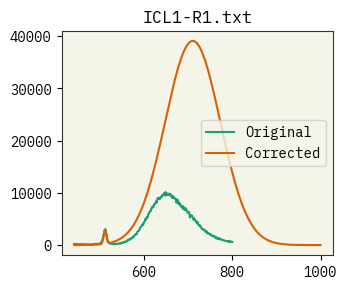

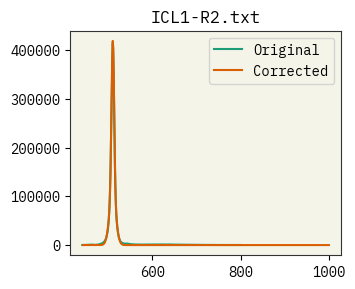

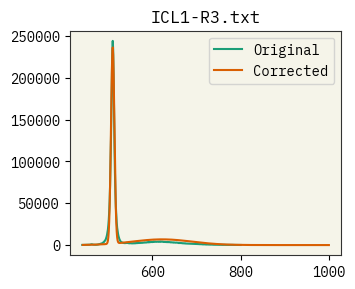

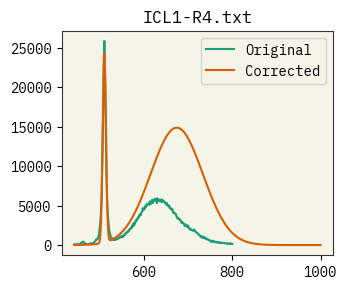

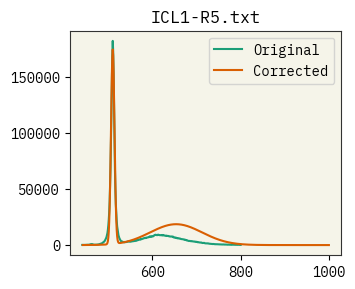

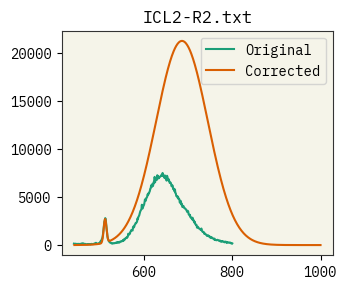

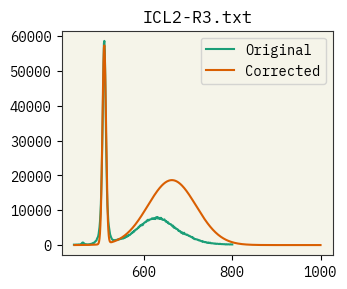

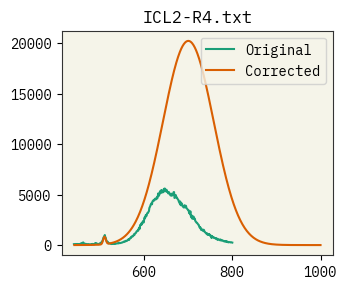

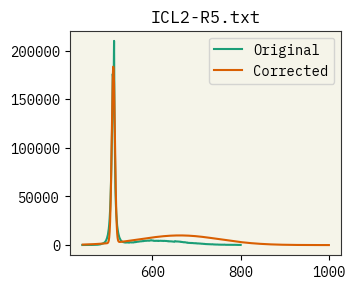

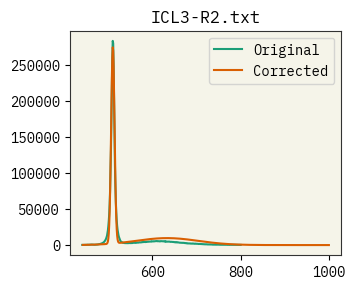

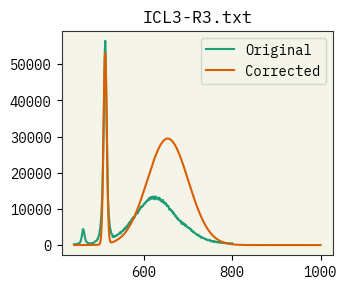

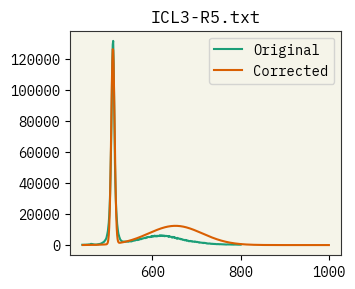

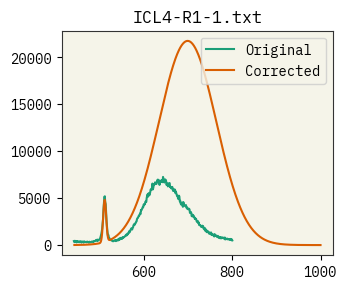

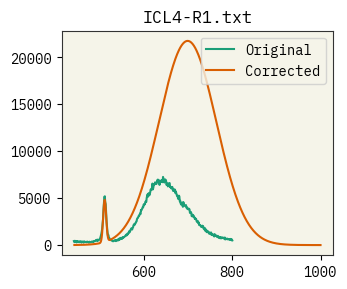

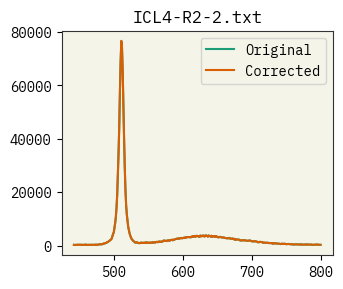

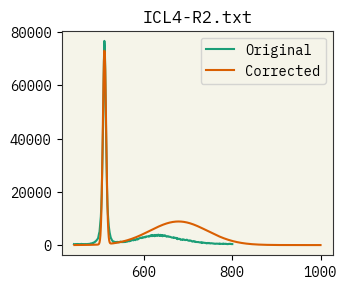

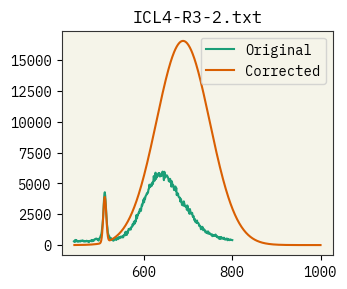

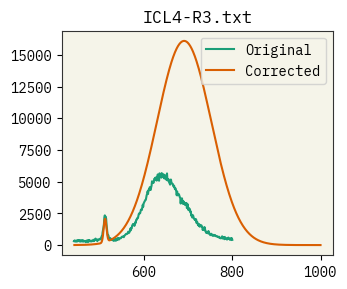

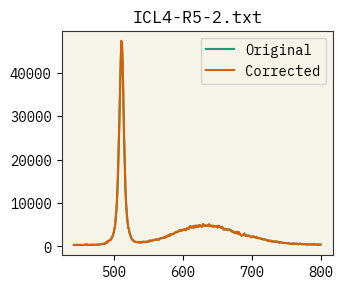

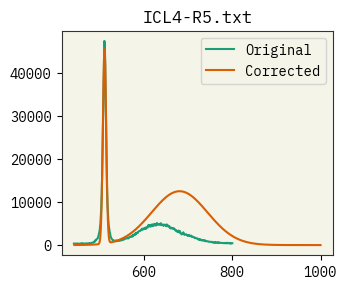

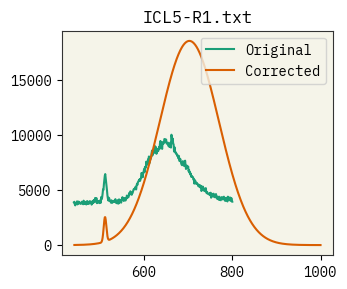

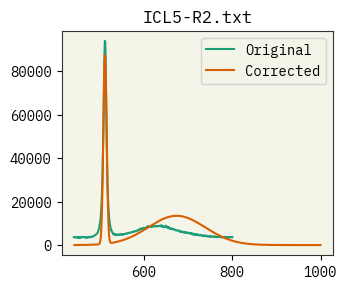

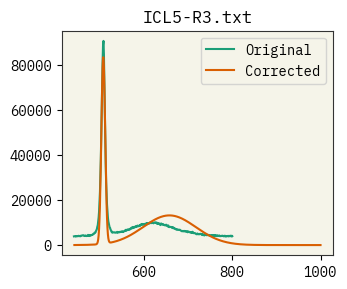

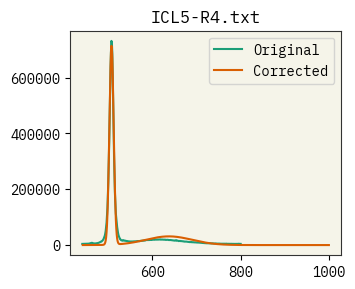

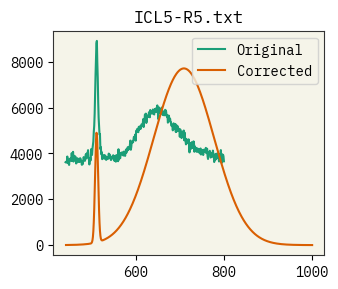

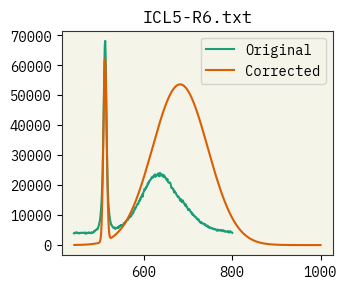

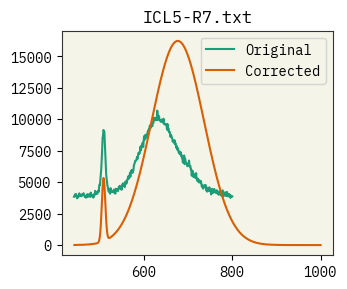

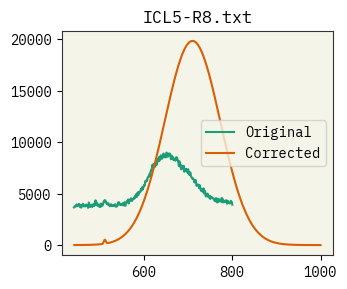

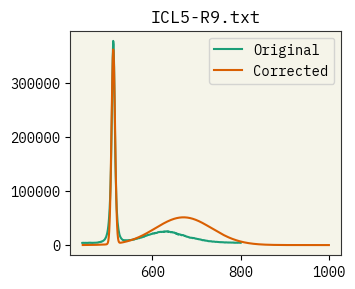

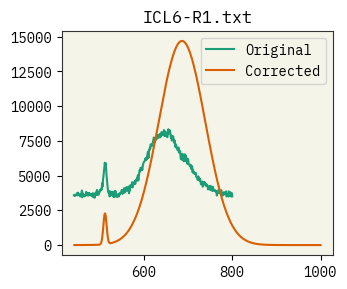

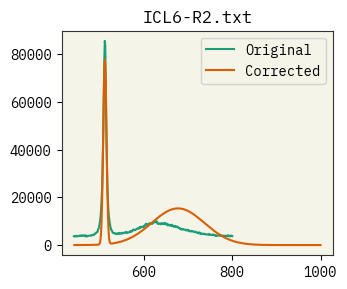

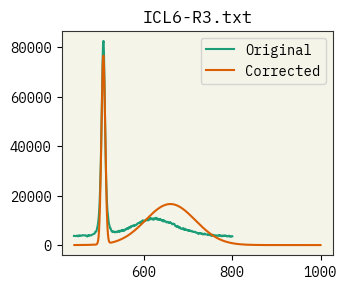

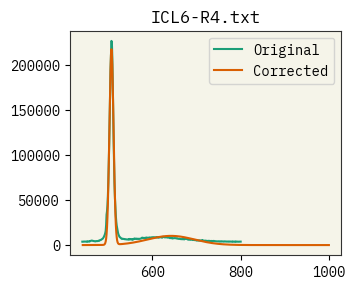

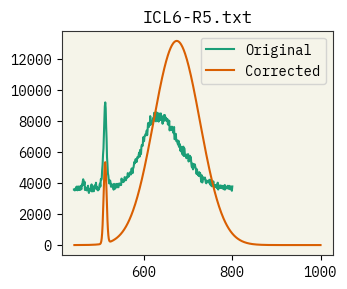

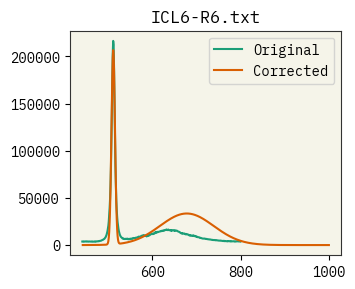

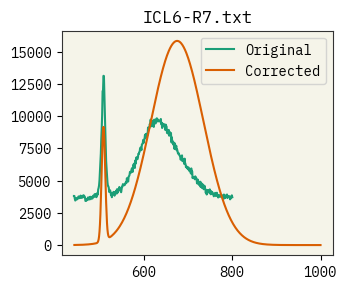

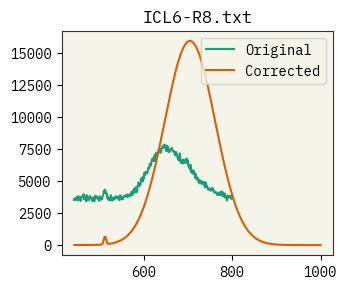

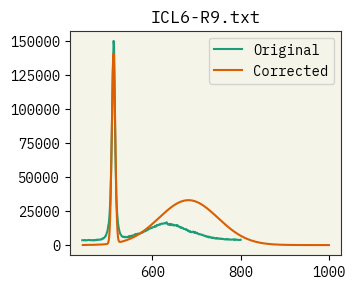

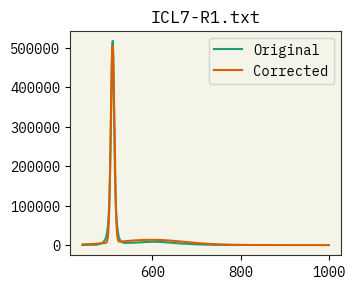

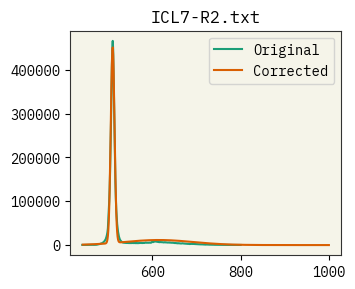

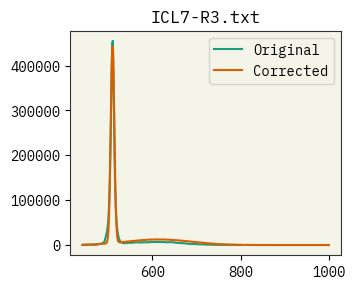

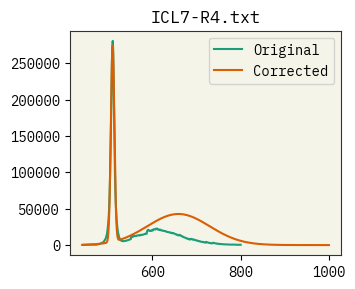

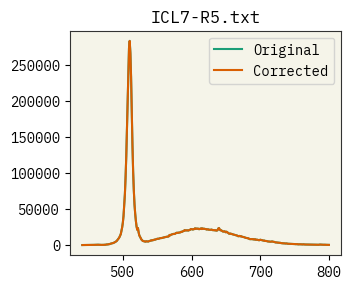

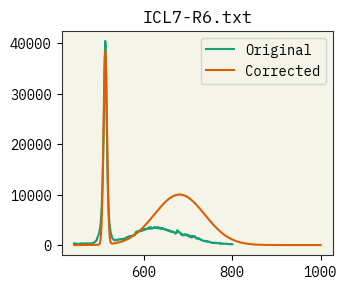

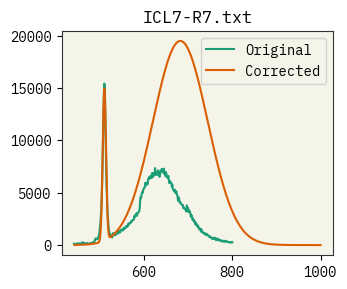

In [10]:
#plot the corrected data and the non correcte data 
directory = './Data/proposed_trials/NLP'
files = sorted(os.listdir(directory))
files = [file for file in files if ".txt" in file]
files = [file for file in files if "_corrected" not in file]
for file in files:
    tmp = pd.read_csv(path+file, sep='\t').to_numpy()
    try:
        tmpC = pd.read_csv(path+file.split('.')[0]+'_corrected.txt', sep='\t').to_numpy()
    except:
        tmpC = pd.read_csv(path+file, sep='\t').to_numpy()
    plt.plot(tmp[:,0],tmp[:,1],label='Original')
    plt.plot(tmpC[:,0],tmpC[:,1],label='Corrected')
    plt.title(file)
    plt.legend()
    plt.show()
#make the same but for each directory, put them all in the same plot



## Util functions to process Spectre information

In [15]:
import numpy as np 
import pandas as pd
import os
# TODO: Refactor all these functions to take into account that we also have abs spectra now

def get_sd_object(wavelengths, intensities):

    assert len(wavelengths) == len(intensities)
    # Process fluorescence data
    spectral_df = {wavelengths[i]: intensities[i] for i in range(len(wavelengths))}
    # print(spectral_df)
    sd = colour.SpectralDistribution(spectral_df)
    return sd

# plot_single_sd(sd,title = 'Trial 16 \n QY:0.8 | AUC2: 0.82 | F:0.65',x_label='Wavelength (nm)',ylabel='Intensity',axes_fontsize=30 )
def plot_spectra(sd,title=''):
    ax = plot_single_sd(
        sd,
        # title='Trial 16 \n QY:0.8 | AUC2: 0.82 | F:0.65',
        title=title,
        x_label='Wavelength (nm)',
        set_ylabel='Intensity',
    
    )
    
    # Customize the font size
    ax[1].set_xlabel('Wavelength (nm)', fontsize=14)
    ax[1].set_ylabel('Intensity', fontsize=18)
    # ax[1].title.set_fontsize(16)  # Title font size
    #change the title to: Trial 16 QY:0.8, AUC2: 0.82, F:0.65
    # plt.title('Trial 16 QY:0.8, AUC2: 0.82, F:0.65')
    #add vertical lines at 450, and 950
    ax[1].axvline(x=450, color='r', linestyle='--')
    ax[1].axvline(x=950, color='r', linestyle='--')
    # # 
    # plt.show()

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 950)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapezoid(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 530)[0][0]
    p2_i = np.where(x == 530)[0][0]
    p2_e = np.where(x == 950)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapezoid(y1, x1)/norm, np.trapezoid(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

def smooth_spectrum(x, y, window=4):
    y = np.array(y)
    y_smooth = np.zeros_like(y)
    for i in range(len(y)):
        if i < window:
            y_smooth[i] = np.mean(y[:i+window])
        elif i > len(y) - window:
            y_smooth[i] = np.mean(y[i-window:])
        else:
            y_smooth[i] = np.mean(y[i-window:i+window])
    return x, y_smooth.tolist()

## Get f=AUC2*QY for new data

['ICL1-R3.csv', 'ICL7-R5-4_corrected.txt', 'ICL1-R2.csv', 'ICL2-R5_corrected.txt', 'ICL3-R5.csv', 'ICL6-R2_corrected.txt', 'ICL1-R3_corrected.txt', 'ICL5-R4_corrected.txt', 'ICL2-R4.txt', 'ICL2-R5.txt', 'ICL6-R6_corrected.txt', 'ICL1-R1.csv', 'ICL6-R1_corrected.txt', 'ICL5-R7_corrected.txt', 'ICL1-R5.csv', 'ICL5-R8.txt', 'ICL5-R9.txt', 'ICL2-R2_corrected.txt', 'ICL6-R5_corrected.txt', 'ICL1-R4.csv', 'ICL1-R4_corrected.txt', 'ICL5-R3_corrected.txt', 'ICL6-R2-T3.csv', 'ICL3-R3.csv', 'ICL2-R2.txt', 'ICL2-R3.txt', 'ICL3-R2.csv', 'ICL7-R1.csv', 'ICL4-R5.txt', 'ICL5-R4.csv', 'ICL5-R5.csv', 'ICL6-R1.txt', 'ICL4-R3-2.csv', 'ICL7-R2.csv', 'ICL5-R9_corrected.txt', 'ICL6-R3.txt', 'ICL5-R7.csv', 'ICL7-R6_corrected.txt', 'ICL5-R6.csv', 'ICL6-R2.txt', 'ICL7-R2_corrected.txt', 'ICL6-R6-T3.csv', 'ICL3-R5_corrected.txt', 'ICL7-R3.csv', 'ICL7-R7.csv', 'ICL4-R3_corrected.txt', 'ICL4-R3.txt', 'ICL6-R6.txt', 'ICL5-R2.csv', 'ICL3-R2_corrected.txt', 'ICL6-R8_corrected.txt', 'ICL5-R3.csv', 'ICL6-R7.txt', 'ICL

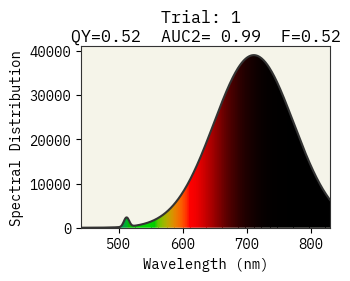

0.099194 absorbance at 430 ICL1-R1.csv ICL1-R1_corrected.txt
ICL1-R1_corrected.txt QY: 0.523703764082 AUC2: 0.994640053639 f: 0.520896739998
AUC_cumaring:  4274430.05971
at 430nm 0.032618 absorbance at 430 ICL1-R2.csv ICL1-R2_corrected.txt


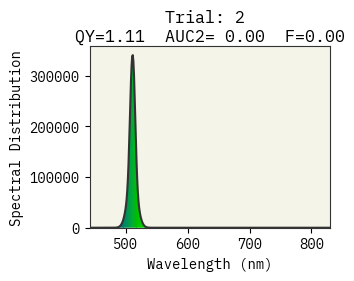

0.032618 absorbance at 430 ICL1-R2.csv ICL1-R2_corrected.txt
ICL1-R2_corrected.txt QY: 1.11157521632 AUC2: 0.00218437908044 f: 0.00242810164888
AUC_cumaring:  3396147.38256
at 430nm 0.032145 absorbance at 430 ICL1-R3.csv ICL1-R3_corrected.txt


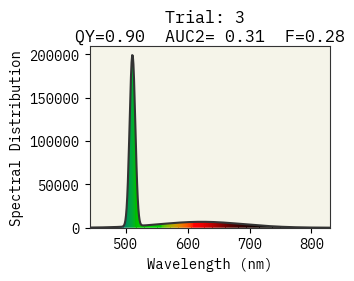

0.032145 absorbance at 430 ICL1-R3.csv ICL1-R3_corrected.txt
ICL1-R3_corrected.txt QY: 0.896171373727 AUC2: 0.311359990465 f: 0.279031910379
AUC_cumaring:  2425482.40115
at 430nm 0.031933 absorbance at 430 ICL1-R4.csv ICL1-R4_corrected.txt


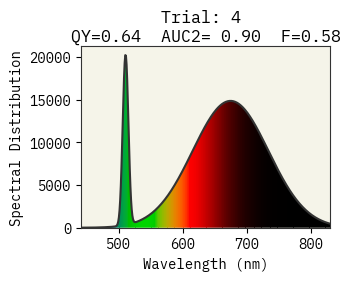

0.031933 absorbance at 430 ICL1-R4.csv ICL1-R4_corrected.txt
ICL1-R4_corrected.txt QY: 0.644282559134 AUC2: 0.903157927485 f: 0.581888900822
AUC_cumaring:  4438522.75497
at 430nm 0.054685 absorbance at 430 ICL1-R5.csv ICL1-R5_corrected.txt


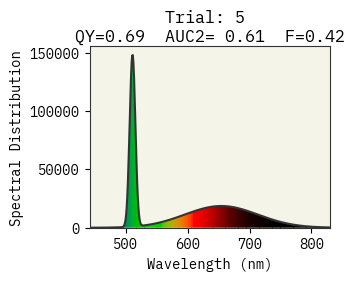

0.054685 absorbance at 430 ICL1-R5.csv ICL1-R5_corrected.txt
ICL1-R5_corrected.txt QY: 0.688475044053 AUC2: 0.608876333393 f: 0.419196160456
AUC_cumaring:  3133538.73983
at 430nm 0.073134 absorbance at 430 ICL2-R2.csv ICL2-R2_corrected.txt


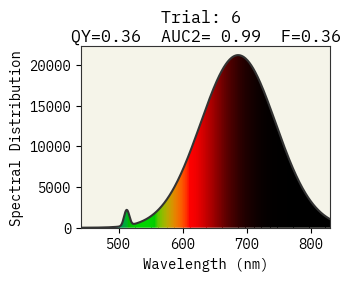

0.073134 absorbance at 430 ICL2-R2.csv ICL2-R2_corrected.txt
ICL2-R2_corrected.txt QY: 0.363440824499 AUC2: 0.990014250827 f: 0.359811595586
AUC_cumaring:  3130350.80375
at 430nm 0.048788 absorbance at 430 ICL2-R3.csv ICL2-R3_corrected.txt


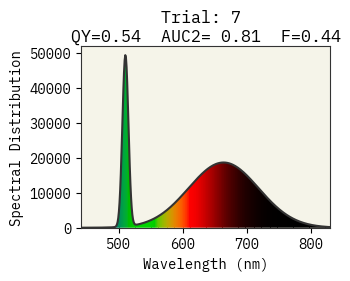

0.048788 absorbance at 430 ICL2-R3.csv ICL2-R3_corrected.txt
ICL2-R3_corrected.txt QY: 0.544249404739 AUC2: 0.810859530627 f: 0.441309816871
AUC_cumaring:  2912933.45579
at 430nm 0.073674 absorbance at 430 ICL2-R4.csv ICL2-R4_corrected.txt


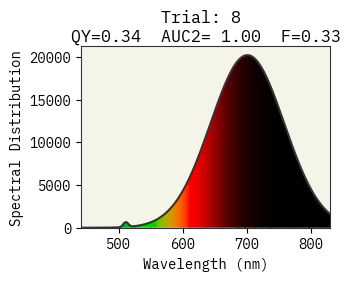

0.073674 absorbance at 430 ICL2-R4.csv ICL2-R4_corrected.txt
ICL2-R4_corrected.txt QY: 0.335377777223 AUC2: 0.996612340377 f: 0.334241631468
AUC_cumaring:  3846538.25666
at 430nm 0.06625 absorbance at 430 ICL2-R5.csv ICL2-R5_corrected.txt


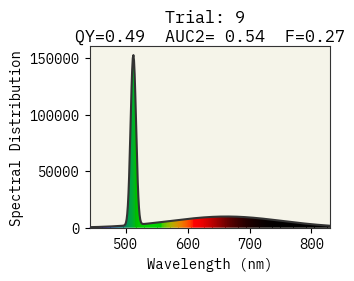

0.06625 absorbance at 430 ICL2-R5.csv ICL2-R5_corrected.txt
ICL2-R5_corrected.txt QY: 0.49249535843 AUC2: 0.540318640597 f: 0.266104422567
AUC_cumaring:  4324836.29994
at 430nm 0.047895 absorbance at 430 ICL3-R2.csv ICL3-R2_corrected.txt


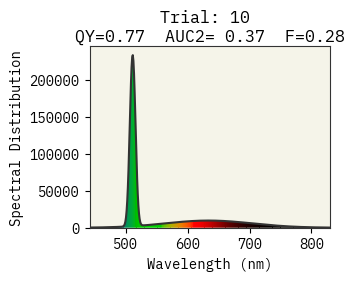

0.047895 absorbance at 430 ICL3-R2.csv ICL3-R2_corrected.txt
ICL3-R2_corrected.txt QY: 0.765944786098 AUC2: 0.36787523099 f: 0.281772115111
AUC_cumaring:  3926941.29758
at 430nm 0.111063 absorbance at 430 ICL3-R3.csv ICL3-R3_corrected.txt


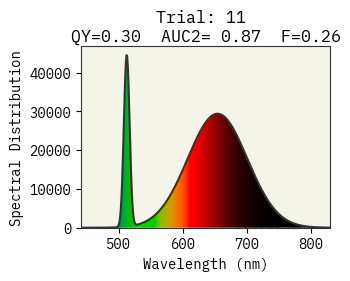

0.111063 absorbance at 430 ICL3-R3.csv ICL3-R3_corrected.txt
ICL3-R3_corrected.txt QY: 0.299918307854 AUC2: 0.871523401027 f: 0.261385823691
AUC_cumaring:  3100459.83502
at 430nm 0.047993 absorbance at 430 ICL3-R5.csv ICL3-R5_corrected.txt


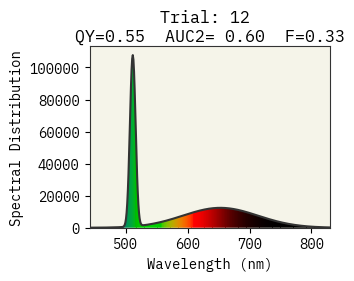

0.047993 absorbance at 430 ICL3-R5.csv ICL3-R5_corrected.txt
ICL3-R5_corrected.txt QY: 0.547981856953 AUC2: 0.59712345572 f: 0.327212820095
AUC_cumaring:  3570566.49399
at 430nm 0.055494 absorbance at 430 ICL4-R1.csv ICL4-R1_corrected.txt


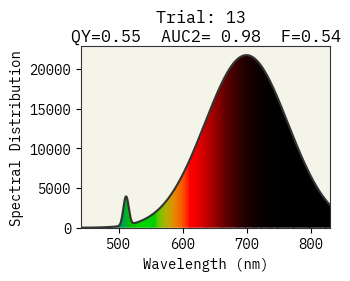

0.055494 absorbance at 430 ICL4-R1.csv ICL4-R1_corrected.txt
ICL4-R1_corrected.txt QY: 0.545769251117 AUC2: 0.984962336991 f: 0.537562157038
AUC_cumaring:  2127791.01594
at 430nm 0.024912 absorbance at 430 ICL4-R2.csv ICL4-R2_corrected.txt


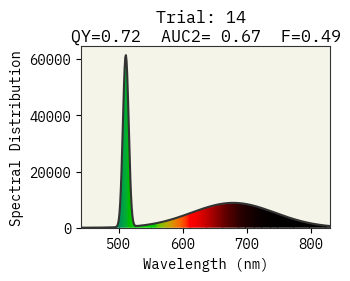

0.024912 absorbance at 430 ICL4-R2.csv ICL4-R2_corrected.txt
ICL4-R2_corrected.txt QY: 0.72449992337 AUC2: 0.671185094982 f: 0.486273549881
AUC_cumaring:  2532174.95752
at 430nm 0.026988 absorbance at 430 ICL4-R3-2.csv ICL4-R3-2_corrected.txt


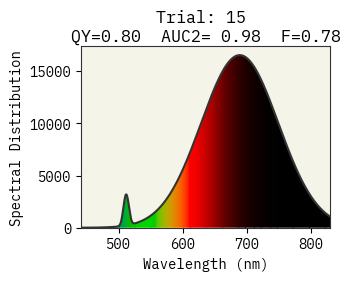

0.026988 absorbance at 430 ICL4-R3-2.csv ICL4-R3-2_corrected.txt
ICL4-R3-2_corrected.txt QY: 0.795867877398 AUC2: 0.983519931332 f: 0.782751920127
AUC_cumaring:  2491250.14781
at 430nm 0.05988 absorbance at 430 ICL4-R3.csv ICL4-R3_corrected.txt


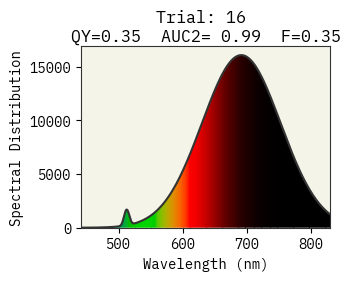

0.05988 absorbance at 430 ICL4-R3.csv ICL4-R3_corrected.txt
ICL4-R3_corrected.txt QY: 0.352901507898 AUC2: 0.989802502232 f: 0.349302795559
AUC_cumaring:  2404103.70747
at 430nm 0.025624 absorbance at 430 ICL4-R5.csv ICL4-R5_corrected.txt


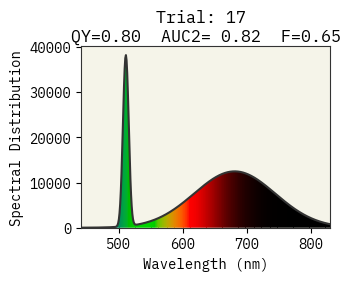

0.025624 absorbance at 430 ICL4-R5.csv ICL4-R5_corrected.txt
ICL4-R5_corrected.txt QY: 0.795837209464 AUC2: 0.817701732506 f: 0.650757464972
AUC_cumaring:  3121641.03797
at 430nm 0.031878 absorbance at 430 ICL5-R1.csv ICL5-R1_corrected.txt


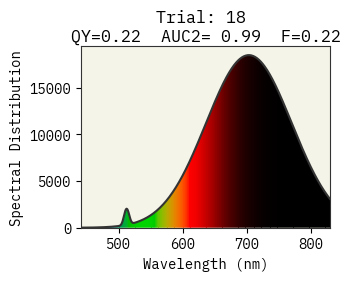

0.031878 absorbance at 430 ICL5-R1.csv ICL5-R1_corrected.txt
ICL5-R1_corrected.txt QY: 0.218978347345 AUC2: 0.98976570312 f: 0.216737257928
AUC_cumaring:  2990829.76364
at 430nm 0.028792 absorbance at 430 ICL5-R2.csv ICL5-R2_corrected.txt


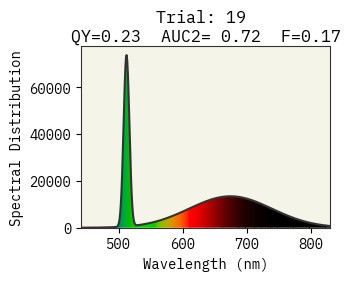

0.028792 absorbance at 430 ICL5-R2.csv ICL5-R2_corrected.txt
ICL5-R2_corrected.txt QY: 0.232289264521 AUC2: 0.718416958919 f: 0.166880547007
AUC_cumaring:  2854689.09896
at 430nm 0.031612 absorbance at 430 ICL5-R3.csv ICL5-R3_corrected.txt


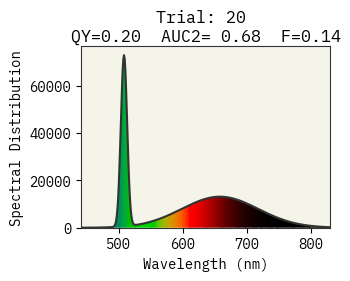

0.031612 absorbance at 430 ICL5-R3.csv ICL5-R3_corrected.txt
ICL5-R3_corrected.txt QY: 0.201937103197 AUC2: 0.678737445399 f: 0.137062273555
AUC_cumaring:  12684045.6539
at 430nm 0.079609 absorbance at 430 ICL5-R4.csv ICL5-R4_corrected.txt


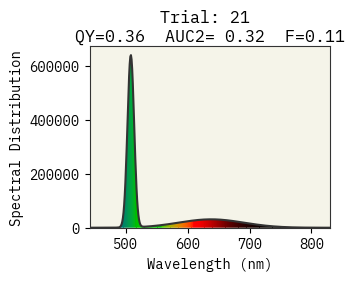

0.079609 absorbance at 430 ICL5-R4.csv ICL5-R4_corrected.txt
ICL5-R4_corrected.txt QY: 0.356291044656 AUC2: 0.31733929995 f: 0.11306515069
AUC_cumaring:  1364090.43412
at 430nm 0.030959 absorbance at 430 ICL5-R5.csv ICL5-R5_corrected.txt


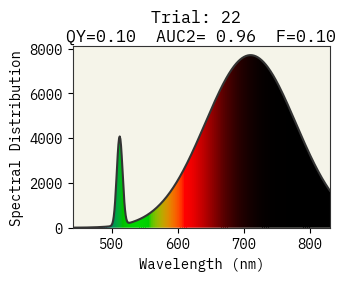

0.030959 absorbance at 430 ICL5-R5.csv ICL5-R5_corrected.txt
ICL5-R5_corrected.txt QY: 0.0985293273291 AUC2: 0.964662098137 f: 0.0950475076293
AUC_cumaring:  8975530.00306
at 430nm 0.058546 absorbance at 430 ICL5-R6.csv ICL5-R6_corrected.txt


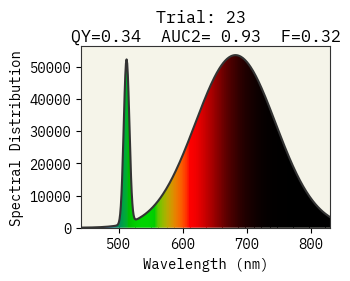

0.058546 absorbance at 430 ICL5-R6.csv ICL5-R6_corrected.txt
ICL5-R6_corrected.txt QY: 0.342824738349 AUC2: 0.930908052603 f: 0.319138309561
AUC_cumaring:  2470383.07694
at 430nm 0.033534 absorbance at 430 ICL5-R7.csv ICL5-R7_corrected.txt


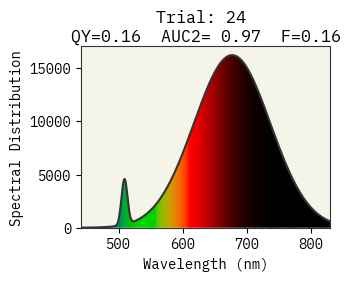

0.033534 absorbance at 430 ICL5-R7.csv ICL5-R7_corrected.txt
ICL5-R7_corrected.txt QY: 0.164735888349 AUC2: 0.973411312778 f: 0.16035577734
AUC_cumaring:  3134221.9868
at 430nm 0.030517 absorbance at 430 ICL5-R8.csv ICL5-R8_corrected.txt


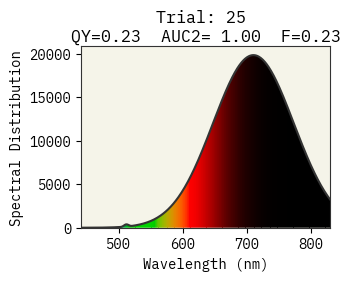

0.030517 absorbance at 430 ICL5-R8.csv ICL5-R8_corrected.txt
ICL5-R8_corrected.txt QY: 0.229666257694 AUC2: 0.997169600141 f: 0.229016210351
AUC_cumaring:  11807641.8604
at 430nm 0.064265 absorbance at 430 ICL5-R9.csv ICL5-R9_corrected.txt


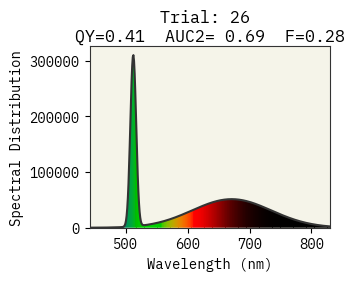

0.064265 absorbance at 430 ICL5-R9.csv ICL5-R9_corrected.txt
ICL5-R9_corrected.txt QY: 0.410863856976 AUC2: 0.686815279226 f: 0.282187574653
AUC_cumaring:  1958630.77228
at 430nm 0.033054 absorbance at 430 ICL6-R1-T3.csv ICL6-R1_corrected.txt


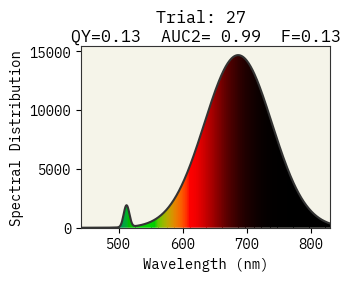

0.033054 absorbance at 430 ICL6-R1-T3.csv ICL6-R1_corrected.txt
ICL6-R1_corrected.txt QY: 0.132506697276 AUC2: 0.988160436529 f: 0.130937875824
AUC_cumaring:  3004019.45882
at 430nm 0.029692 absorbance at 430 ICL6-R2-T3.csv ICL6-R2_corrected.txt


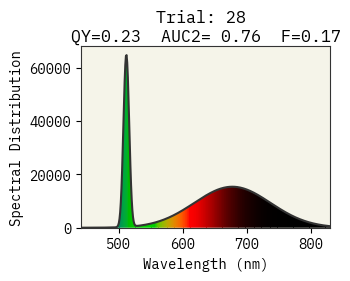

0.029692 absorbance at 430 ICL6-R2-T3.csv ICL6-R2_corrected.txt
ICL6-R2_corrected.txt QY: 0.22624165458 AUC2: 0.757725843039 f: 0.171429148447
AUC_cumaring:  3161868.99693
at 430nm 0.036155 absorbance at 430 ICL6-R3-T3.csv ICL6-R3_corrected.txt


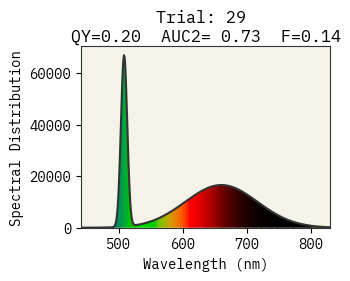

0.036155 absorbance at 430 ICL6-R3-T3.csv ICL6-R3_corrected.txt
ICL6-R3_corrected.txt QY: 0.195562141775 AUC2: 0.734698320068 f: 0.143679177031
AUC_cumaring:  3874566.74617
at 430nm 0.077772 absorbance at 430 ICL6-R4-T3.csv ICL6-R4_corrected.txt


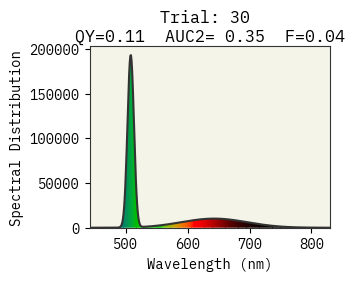

0.077772 absorbance at 430 ICL6-R4-T3.csv ICL6-R4_corrected.txt
ICL6-R4_corrected.txt QY: 0.111406147911 AUC2: 0.345639919351 f: 0.0385064119792
AUC_cumaring:  1775462.78444
at 430nm 0.029583 absorbance at 430 ICL6-R5-T3.csv ICL6-R5_corrected.txt


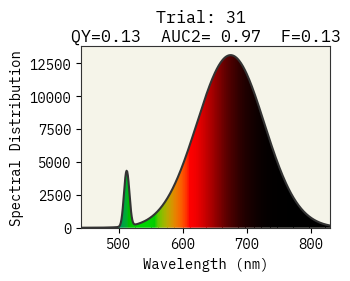

0.029583 absorbance at 430 ICL6-R5-T3.csv ICL6-R5_corrected.txt
ICL6-R5_corrected.txt QY: 0.134208072349 AUC2: 0.972413397882 f: 0.130505727656
AUC_cumaring:  7129737.7812
at 430nm 0.067199 absorbance at 430 ICL6-R6-T3.csv ICL6-R6_corrected.txt


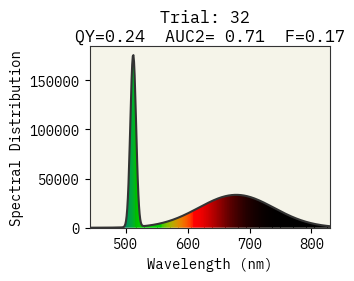

0.067199 absorbance at 430 ICL6-R6-T3.csv ICL6-R6_corrected.txt
ICL6-R6_corrected.txt QY: 0.23725754153 AUC2: 0.711385469023 f: 0.16878156746
AUC_cumaring:  2455165.58208
at 430nm 0.031566 absorbance at 430 ICL6-R7-T3.csv ICL6-R7_corrected.txt


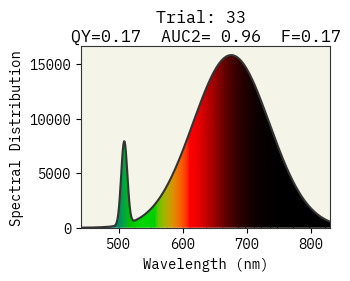

0.031566 absorbance at 430 ICL6-R7-T3.csv ICL6-R7_corrected.txt
ICL6-R7_corrected.txt QY: 0.173928404765 AUC2: 0.95594037968 f: 0.166265185288
AUC_cumaring:  2291801.06889
at 430nm 0.02583 absorbance at 430 ICL6-R8-T3.csv ICL6-R8_corrected.txt


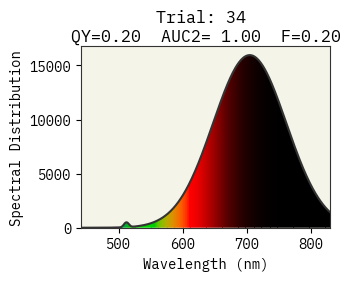

0.02583 absorbance at 430 ICL6-R8-T3.csv ICL6-R8_corrected.txt
ICL6-R8_corrected.txt QY: 0.19840919273 AUC2: 0.997040655509 f: 0.197822031578
AUC_cumaring:  6862212.20143
at 430nm 0.067908 absorbance at 430 ICL6-R9-T3.csv ICL6-R9_corrected.txt


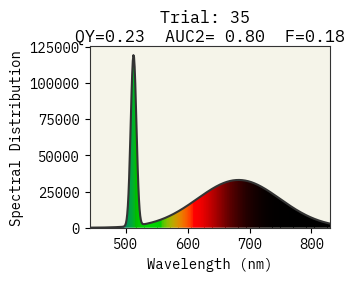

0.067908 absorbance at 430 ICL6-R9-T3.csv ICL6-R9_corrected.txt
ICL6-R9_corrected.txt QY: 0.225970882833 AUC2: 0.79587485659 f: 0.179844543968
AUC_cumaring:  7526232.30427
at 430nm 0.046291 absorbance at 430 ICL7-R1.csv ICL7-R1_corrected.txt


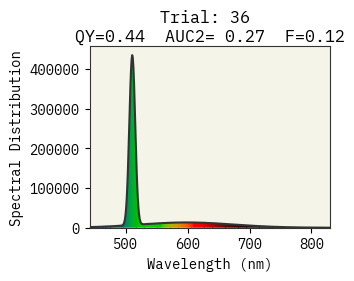

0.046291 absorbance at 430 ICL7-R1.csv ICL7-R1_corrected.txt
ICL7-R1_corrected.txt QY: 0.441546922251 AUC2: 0.274340452017 f: 0.121134182237
AUC_cumaring:  6962607.97554
at 430nm 0.034711 absorbance at 430 ICL7-R2.csv ICL7-R2_corrected.txt


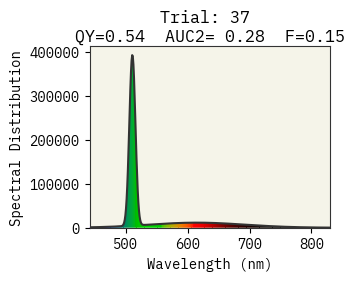

0.034711 absorbance at 430 ICL7-R2.csv ICL7-R2_corrected.txt
ICL7-R2_corrected.txt QY: 0.544754245025 AUC2: 0.278559358911 f: 0.151746393258
AUC_cumaring:  6725192.22403
at 430nm 0.032434 absorbance at 430 ICL7-R3.csv ICL7-R3_corrected.txt


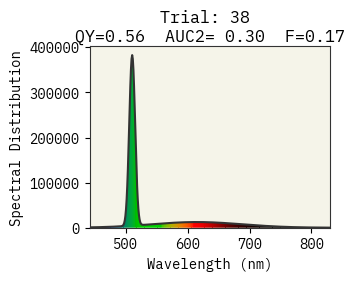

0.032434 absorbance at 430 ICL7-R3.csv ICL7-R3_corrected.txt
ICL7-R3_corrected.txt QY: 0.563118759278 AUC2: 0.301279436721 f: 0.169656102603
AUC_cumaring:  10230743.3634
at 430nm 0.071816 absorbance at 430 ICL7-R4.csv ICL7-R4_corrected.txt


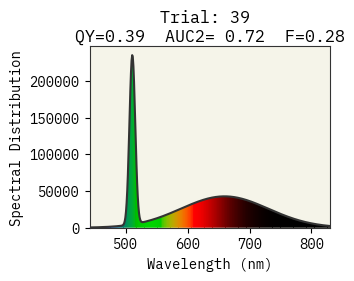

0.071816 absorbance at 430 ICL7-R4.csv ICL7-R4_corrected.txt
ICL7-R4_corrected.txt QY: 0.386884903813 AUC2: 0.715207483848 f: 0.276702978595
AUC_cumaring:  10925820.8181
at 430nm 0.064016 absorbance at 430 ICL7-R5.csv ICL7-R5-4_corrected.txt


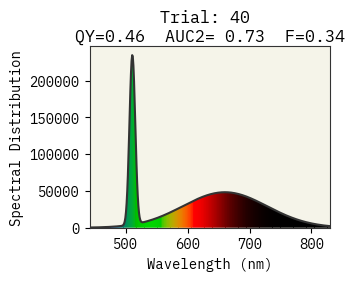

0.064016 absorbance at 430 ICL7-R5.csv ICL7-R5-4_corrected.txt
ICL7-R5-4_corrected.txt QY: 0.463512387597 AUC2: 0.734288217619 f: 0.340351684933
AUC_cumaring:  1807560.37001
at 430nm 0.032962 absorbance at 430 ICL7-R6.csv ICL7-R6_corrected.txt


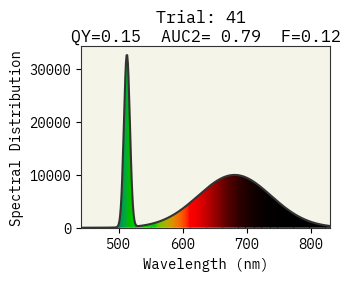

0.032962 absorbance at 430 ICL7-R6.csv ICL7-R6_corrected.txt
ICL7-R6_corrected.txt QY: 0.148927555666 AUC2: 0.786596166554 f: 0.117145844381
AUC_cumaring:  3166982.63035
at 430nm 0.035529 absorbance at 430 ICL7-R7.csv ICL7-R7_corrected.txt


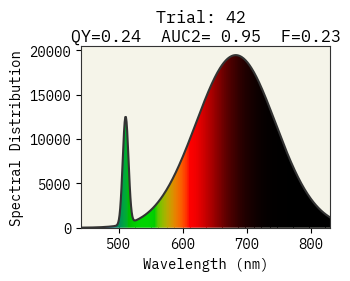

0.035529 absorbance at 430 ICL7-R7.csv ICL7-R7_corrected.txt
ICL7-R7_corrected.txt QY: 0.242079772744 AUC2: 0.950843904399 f: 0.230180076292


In [18]:
#get list of files in Data/fluoressence_data starting in M
import os
import matplotlib.pyplot as plt
files = os.listdir('/Users/jorgemedina/BioNano-DOE/AgML/Data/proposed_trials/NLP')
files_2 = os.listdir('./Data/proposed_trials/NLP')
#files = os.listdir('Data/fluorescence_data/proposed_trials/NLP/')
#split files in two lists, one .txt and one .csv
txt_files = [file for file in files if file.endswith('.txt') and 'corrected' in file]
csv_files = [file for file in files_2 if file.endswith('.csv') ]
print(files_2, csv_files)
#organize them together such that the first .txt file corresponds to the first .csv file
txt_files.sort() #To make sure they are zipped in the right order correctly
csv_files.sort() #To make sure they are zipped in the right order correctly
print(txt_files)
print(csv_files)
for i, (txt, csv) in enumerate(zip(txt_files, csv_files)):
    try:
        with open(f"/Users/jorgemedina/BioNano-DOE/AgML/Data/proposed_trials/NLP/{txt}", 'r',encoding='utf-8-sig') as input:
                    lines = input.readlines()
                    x = []
                    y = []
                    for line in lines:
                        x.append(float(line.split()[0]))
                        y.append(float(line.split()[1]))
                    y = [yi-min(y) for yi in y]
                    f_x, f_y = smooth_spectrum(x, y)
                    

                    fl_int_norm = [yi/max(f_y) for yi in f_y]
                    fl_auc_total = get_area_under_peaks(f_x, f_y)
                    peaks, areas = process_spectrum(f_x, f_y, norm_area=fl_auc_total)
                    fl_wvl, fl_int = f_x[:], f_y[:]
                    #print area under the curve
                    print("AUC_cumaring: ",fl_auc_total)
        if os.path.exists(f"/Users/jorgemedina/BioNano-DOE/AgML/Data/proposed_trials/NLP/{csv}"):
                    df = pd.read_csv(f"/Users/jorgemedina/BioNano-DOE/AgML/Data/proposed_trials/NLP/{csv}")
                    df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                    x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                    x, y = smooth_spectrum(x, y)
                    #print absorption at 430nm
                    abs_int_norm = [yi/max(y) for yi in y]
                    print("at 430nm",df[df['nm'] == 430][' A'].values[0],"absorbance at 430", csv, txt)
                    abs_auc_total = get_area_under_peaks(x, y)
                    abs_wvl, abs_int = x[:], y[:]
                    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
                    abs_s = df[df['nm'] == 430][' A'].values[0]
                    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
                    if "ICL5" in txt or "ICL6" in txt:
                        fl_r, abs_r, n_r = 9453221.02, 0.039083, 1.3611
                    elif "ICL7" in txt:
                        fl_r, abs_r, n_r =  8930003.417, 0.044838, 1.3611
                    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
                    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
                    #two decimals
                    sd = get_sd_object(f_x, f_y)
                    _title = f"Trial: {i+1} \nQY={qy:.2f}  AUC2= {areas[1]:.2f}  F={qy*areas[1]:.2f}"
                    plot_spectra(sd,title = _title)#,fontsize=10)
                    plt.show()
                    print(abs_s,"absorbance at 430", csv, txt)
    except Exception as e:
           print(f"Exception at {txt} and {csv}")
           print(e)
           continue
    print(txt,"QY:",qy, "AUC2:", areas[1],"f:", qy*areas[1])

In [11]:
import os
import matplotlib.pyplot as plt
files = os.listdir('./Data/proposed_trials/pre-doping/')
#files = os.listdir('Data/fluorescence_data/proposed_trials/NLP/')
#split files in two lists, one .txt and one .csv
txt_files = [file for file in files if file.endswith('.txt')]
csv_files = [file for file in files if file.endswith('.csv')]
#organize them together such that the first .txt file corresponds to the first .csv file
txt_files.sort() #To make sure they are zipped in the right order correctly
csv_files.sort() #To make sure they are zipped in the right order correctly
for txt,csv in zip(txt_files,csv_files):
    print(txt,csv)

In [ ]:
#get list of files in Data/fluoressence_data starting in M

for i, (txt, csv) in enumerate(zip(txt_files, csv_files)):
    #with open(f"Data/fluorescence_data/proposed_trials/NLP/{txt}", 'r') as input:
    try:
        with open(f"Data/proposed_trials/pre-doping/{txt}", 'r',encoding='utf-8-sig') as input:
                    lines = input.readlines()
                    x = []
                    y = []
                    for line in lines:
                        x.append(float(line.split()[0]))
                        y.append(float(line.split()[1]))
                    y = [yi-min(y) for yi in y]
                    x, y = smooth_spectrum(x, y)
                    #plot_spectrum(x, y, txt)
                    plt.plot(x, y,color='C1')
                    plt.xlabel('Wavelength (nm)')
                    plt.ylabel('Fluorescense Intensity (counts)')

                    fl_int_norm = [yi/max(y) for yi in y]
                    fl_auc_total = get_area_under_peaks(x, y)
                    peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
                    fl_wvl, fl_int = x[:], y[:]
        
        #if os.path.exists(f"Data/fluorescence_data/proposed_trials/NLP/{csv}"):
        if os.path.exists(f"Data/proposed_trials/pre-doping/{csv}"):
                    df = pd.read_csv(f"Data/proposed_trials/pre-doping/{csv}")
                    df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                    x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                    x, y = smooth_spectrum(x, y)
                    abs_int_norm = [yi/max(y) for yi in y]
                    abs_auc_total = get_area_under_peaks(x, y)
                    abs_wvl, abs_int = x[:], y[:]
                    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
                    abs_s = df[df['nm'] == 430][' A'].values[0]
                    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
                    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
                    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
                    #two decimals
                    plt.title(f"Trial: {i+1}| {txt} \nQY={qy:.2f}  AUC2= {areas[1]:.2f}  F={qy*areas[1]:.2f}",fontsize=10)
                    plt.show()
                    print(abs_s,"absorbance at 430",csv)
    except Exception as e:
           print(f"Exception at {txt} and {csv}")
           print(e)
           continue
    print(txt,"QY:",qy,"AUC2:", areas[1],"f:", qy*areas[1])

In [ ]:
#plot the corrected data and the non correcte data on all dirs
for directory in dirs:
    files = sorted(os.listdir(directory))
    for file in files:
        tmp = pd.read_csv(directory+'/'+file, sep='\t').to_numpy()
        try:
            tmpC = pd.read_csv(directory+'/'+file.split('.')[0]+'_corrected.txt', sep='\t').to_numpy()
        except:
            tmpC = pd.read_csv(directory+'/'+file, sep='\t').to_numpy()
        plt.plot(tmp[:,0],tmp[:,1],label='Original')
        plt.plot(tmpC[:,0],tmpC[:,1],label='Corrected')
        plt.legend()
        plt.show()

## Processing raw data

In [ ]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s
experiments = pd.read_csv('Data/experiments.csv')   # Total of 56 experiments of raw data
                                                    # some data is incomplete, and depending on the purpose of the analysis we might want to discard some of it (e.g.
                                                    # we dont have pre-doping absorbance so we cant calculate predoping QY (pre-QY) for some of the NPLs)
processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}_corrected.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            x, y = smooth_spectrum(x, y)
            #substract minimum value to all values
            y = [yi-min(y) for yi in y]
            fl_int_norm = [yi/max(y) for yi in y]
            fl_auc_total = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
            fl_wvl, fl_int = x[:], y[:]

        if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
            df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
            x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
            x, y = smooth_spectrum(x, y)
            abs_int_norm = [yi/max(y) for yi in y]
            abs_auc_total = get_area_under_peaks(x, y)
            abs_wvl, abs_int = x[:], y[:]
            # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
            abs_s = df[df['nm'] == 430][' A'].values[0]
            fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
            fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
            qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
            qypeak1 = 0.53 * (areas[0]*fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
            qypeak2 = 0.53 * (areas[1]*fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
        else:
            print(f"File not available: Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            abs_int_norm = None
            abs_auc_total = None
            abs_wvl, abs_int = None, None
            qy = -1
        #if "pre doping" in folder 
        """Some of the NPLs where measured after synthesis/before doping """
        pre_fl_files = ["NPL-4-Predoping 100x dilution 3mL cuvette.txt",
                 "NPL-11 Pre Doping Stock-100x dilution (3mL).txt",
                 "NPL-17 100x Pre Doping.txt",
                 "NPL-17 100x Pre doping stock.txt",
                 "NPL-12 Pre Doping 100x dil.txt",
                 "NPL-13 Pre Doping 100x dil.txt"]
        pre_abs_files = ["NPL-4 100x Pre Doping .csv",
                         "NPL-11 Pre Doping Stock-100x dilution (3mL).csv",
                         "NPL-17 100x Pre Doping.csv",
                         "NPL-17 100x Pre doping stock.csv",
                         "NPL-12 1x Pre doping 100 x.Sample.Raw.csv",
                         "NPL-13 Pre doping 100 x dil .Sample.Raw.csv"]
        #iterate files in directory.
        for file in os.listdir(f"Data/fluorescence_data/{exp}"):
            if file in pre_fl_files:
                print(file)
                with open(f"Data/fluorescence_data/{exp}/{file[:-4]}_corrected.txt", 'r') as input:
                    lines = input.readlines()
                    x = []
                    y = []
                    for line in lines:
                        x.append(float(line.split()[0]))
                        y.append(float(line.split()[1]))
                    x, y = smooth_spectrum(x, y)

                    y = [yi-min(y) for yi in y]                      #substract minimum value to all values (baseline correction)
                    pre_fl_int_norm = [yi/max(y) for yi in y]
                    pre_fl_auc_total = get_area_under_peaks(x, y)
                    pre_peaks, pre_areas = process_spectrum(x, y, norm_area=fl_auc_total)
                    pre_fl_wvl, pre_fl_int = x[:], y[:]
        flag = 0
        for file in os.listdir(f"Data/absorbance_data/{exp}"):
            if file in pre_abs_files:
                flag = 1
                df = pd.read_csv(f"Data/absorbance_data/{exp}/{file}")
                df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                x, y = smooth_spectrum(x, y)
                abs_int_norm = [yi/max(y) for yi in y]
                abs_auc_total = get_area_under_peaks(x, y)
                abs_wvl, abs_int = x[:], y[:]
                # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
                _pre_abs_s = df[df['nm'] == 430][' A'].values[0]
                _pre_fl_r, _pre_abs_r, n_r = 8272505, 0.129734, 1.3611
                _pre_fl_s, _pre_abs_s, n_s = pre_fl_auc_total, _pre_abs_s, 1.375
                print(pre_fl_auc_total,_pre_fl_r,_pre_abs_r,_pre_abs_s)
                pre_qy = 0.53 * (pre_fl_auc_total/_pre_fl_r) * (_pre_abs_r/_pre_abs_s) * (n_s/n_r)**2
        if flag == 0:
                print(f"File not available: Data/absorbance_data/{exp}")
                pre_abs_int_norm = None
                pre_abs_auc_total = None
                pre_abs_wvl, pre_abs_int = None, None
                pre_qy = -1  #if we dont have pre-doping absorbance we cant calculate pre-doping QY (-1 is the flag to not use the data)
             
        #we add whatever we want to the results_df, we can add other labels here just be sure to calculate them
        #above and any new util function should be added to the top of the file
        results_df = pd.DataFrame({'Temperature(C)': [T], 
                                    'Doping(%)': [d], 
                                    'Time(min)': [t], 
                                    'Peak1': [peaks[0]], 
                                    'Peak2': [peaks[1]], 
                                    'Area1': [areas[0]], 
                                    'Area2': [areas[1]],
                                    'Pre-QY': [pre_qy],
                                    'QY': [qy],
                                    'QY_peak1': [qypeak1],
                                    'QY_peak2': [qypeak2],
                                    # 'Distance_peaks': [peaks[1]-peaks[0]],
                                    # 'ratioP2P1': [areas[1]/areas[0]],
                                    'Fl_Wavelengths': [fl_wvl],
                                    'Fluorescence': [fl_int],
                                    'Fluorescence_norm': [fl_int_norm],
                                    'Abs_Wavelengths': [abs_wvl],
                                    'Absorbance': [abs_int],
                                    'Absorbance_norm': [abs_int_norm]
                                    }) # we can add other labels here
        new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_datawobaseline.csv', index=False)

NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Predoping 100x dilution 3mL cuvette.txt
4307331.211294533 8272505 0.129734 0.100658
NPL-4-Pred

## Making data for Bayesian Optimization with GPs

[  3.20455015e-01   2.43197728e-01   2.44346315e-01   8.96215415e-02
   1.84045620e-03   1.04490725e-01   1.11653604e-01   1.00772745e-01
   9.99231850e-02   1.31224278e-01   1.13140798e-01   1.08569072e-01
   1.00671498e-01   1.40542458e-01   1.35804860e-01   1.77097634e-01
   1.51744119e-01   1.83401179e-01   1.83296982e-01   1.37983337e-01
   1.95619730e-01   1.81695022e-01   3.35840786e-01   3.77497788e-01
   3.02294224e-01   1.97581510e-01   1.85967315e-01   6.28883062e-04
   1.70555409e-01   6.95801622e-04   1.09516119e-01   1.07690048e-01
   9.32045977e-02   2.55510951e-01   5.81775205e-02   2.84187164e-01
   3.21345825e-01   2.57616834e-01   3.79845874e-01   5.79148286e-04
   6.80702804e-06   1.26817969e-05   3.52713712e-02   4.10644388e-07
   3.46398413e-07   3.57379461e-02   1.59835577e-01   6.80507923e-02]
[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447.0, 448.0, 449.0, 450.0, 451.0, 452.0, 453.0, 454.0, 455.0, 456.0, 457.0, 458.0, 459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 46

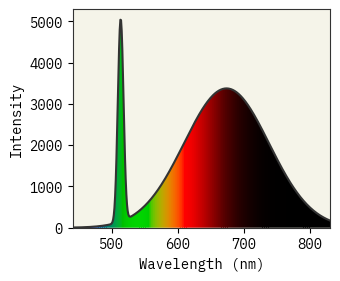

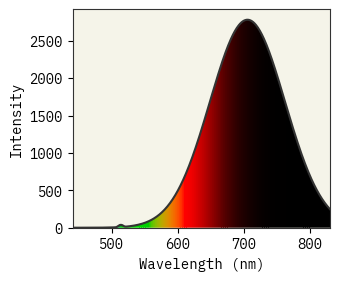

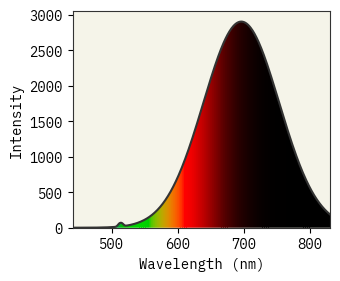

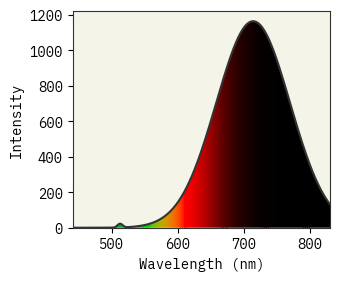

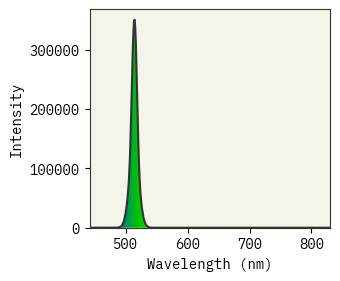

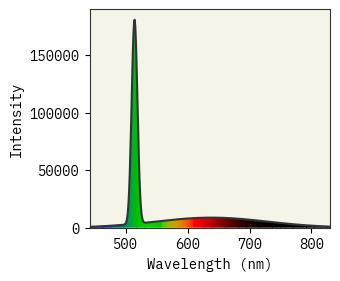

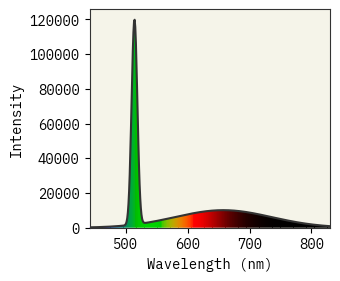

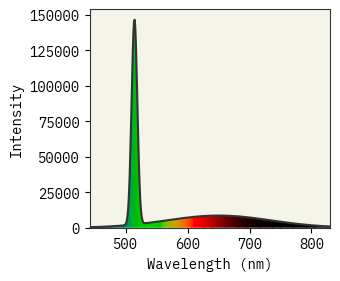

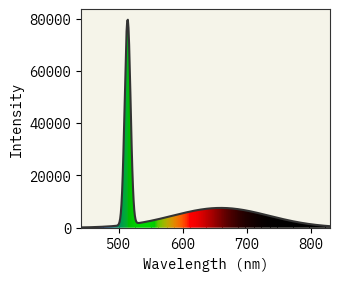

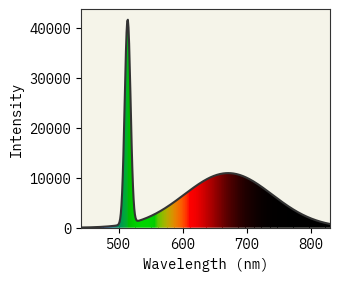

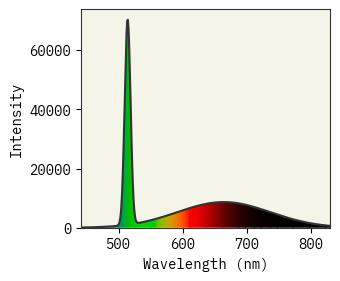

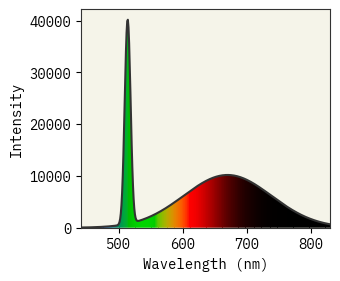

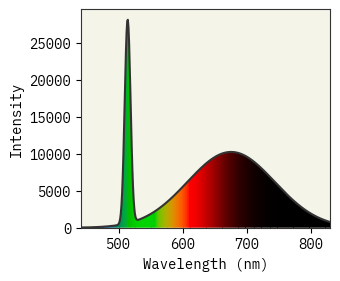

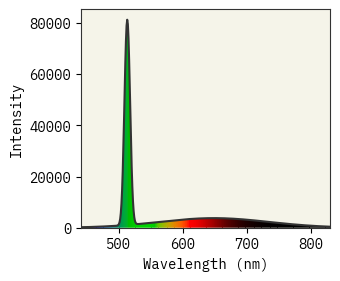

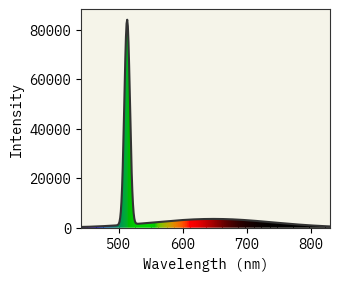

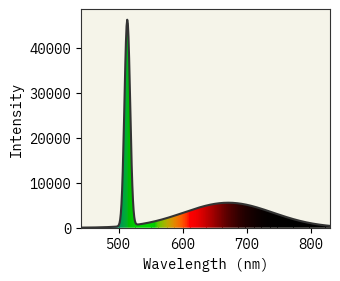

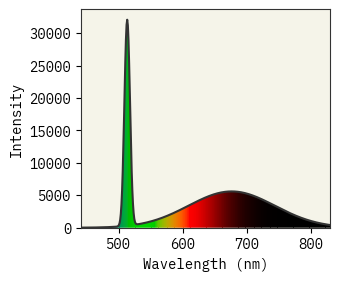

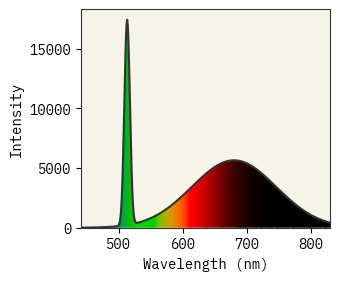

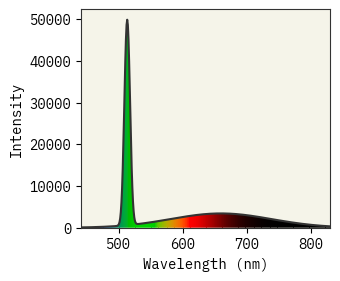

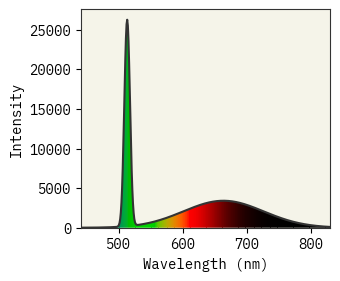

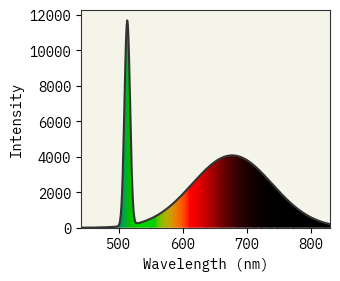

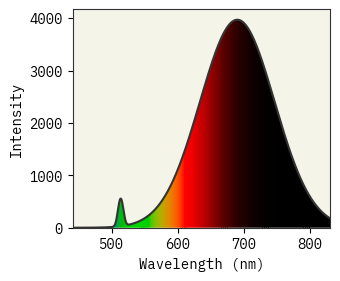

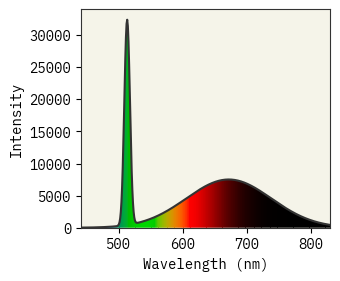

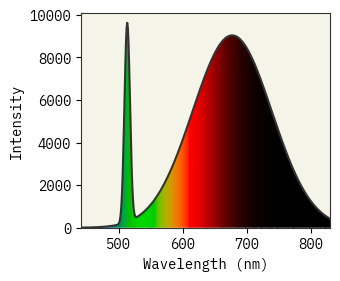

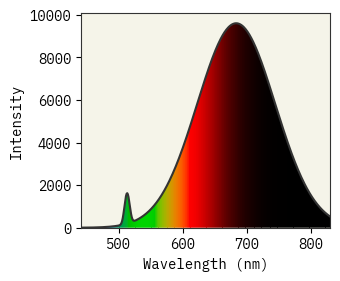

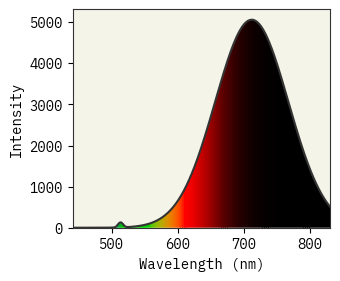

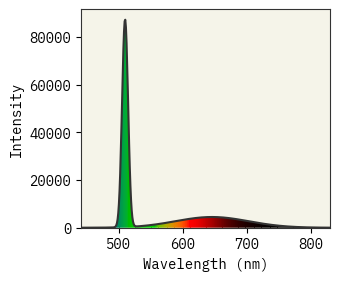

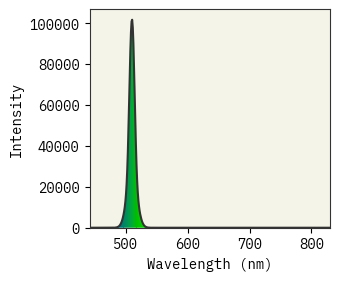

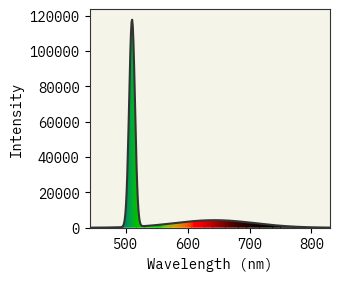

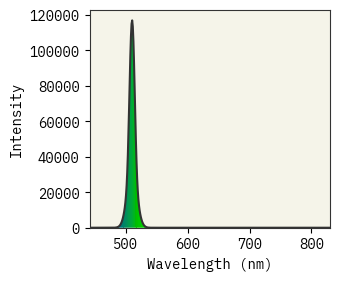

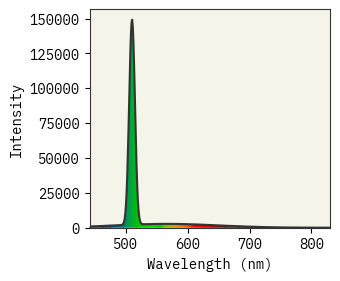

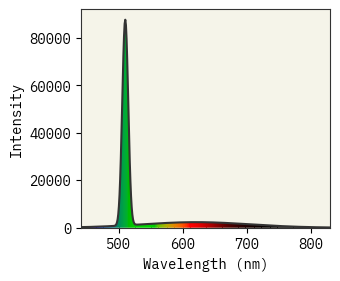

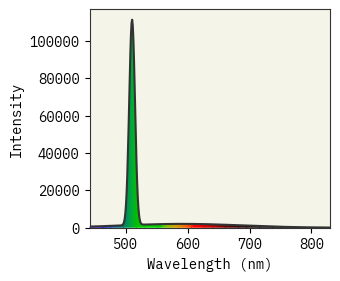

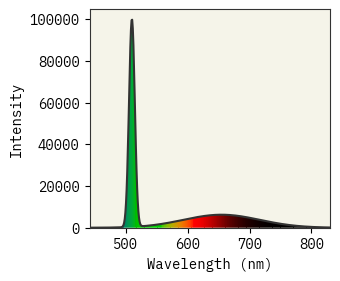

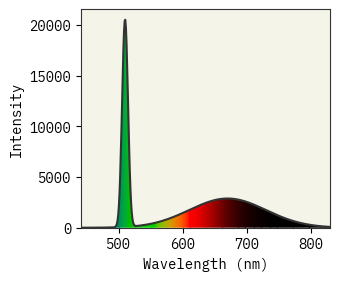

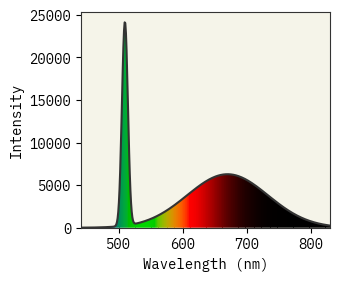

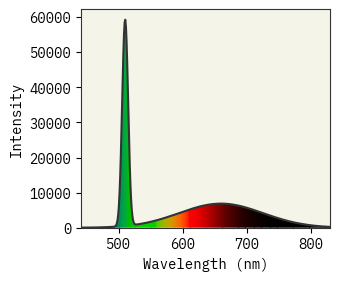

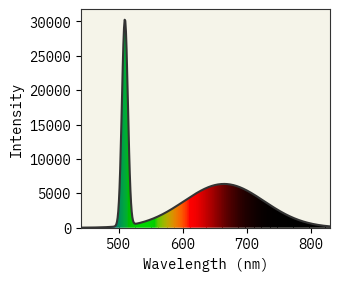

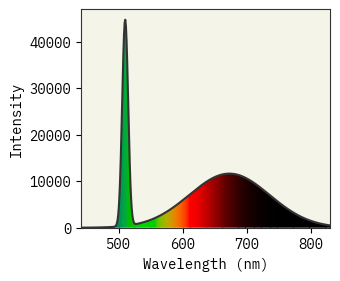

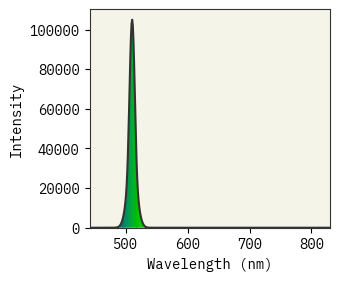

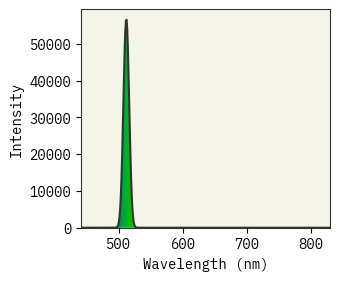

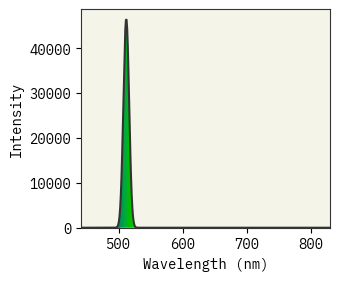

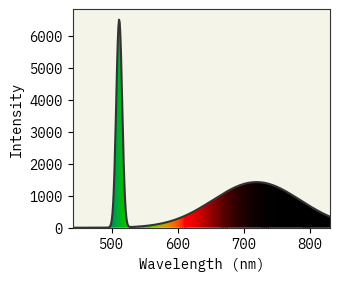

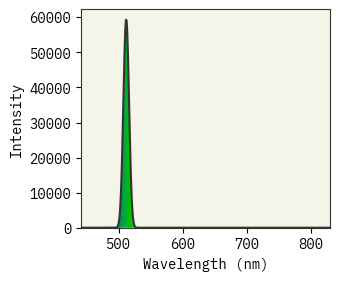

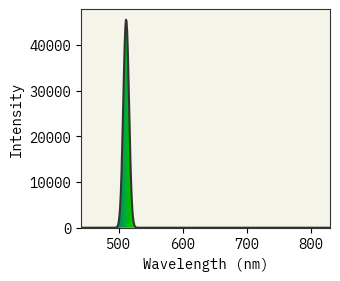

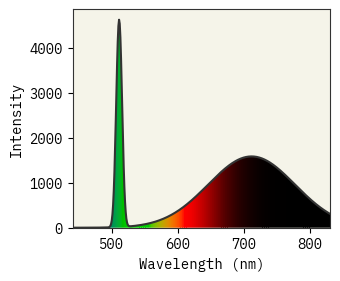

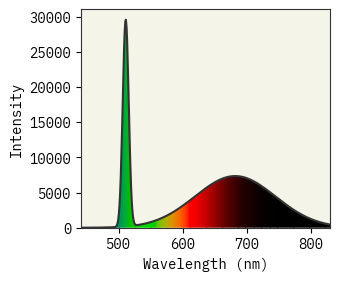

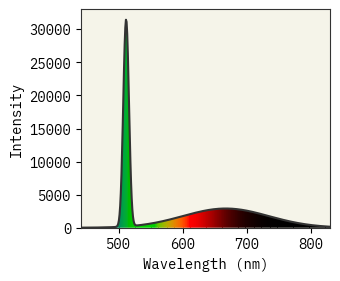

In [ ]:
import ast
df = pd.read_csv('Data/processed_datawobaseline.csv')


#Maintain only Dimension1(nm),Dimension2(nm),OD,Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),AgSol(uL),Time(min),Temperature(C),Experiment,
grouped = df.groupby(['Experiment','Doping(%)', 'Time(min)', 'Temperature(C)'])
features_labels_dict = {}

for name, group in grouped:
    features = group[['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)', 
                      'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)', 
                      'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 
                      'Temperature(C)','Pre-QY','Fl_Wavelengths','Fluorescence']] #we can add more features here or remove some of them

    label = group['Area2']
    label2 = group['QY']

    features_labels_dict[name] = {'features': features, 'label': label, 'labelqy': label2}
group_keys = list(features_labels_dict.keys())

predictions = {}
# Get the group keys for training and testing
train_keys = [group_keys[i] for i in range(len(group_keys)) ]
test_keys = group_keys  # test_keys_index is a list with one elemen
# Prepare the training and testing data
train_features = np.vstack([features_labels_dict[key]['features'] for key in train_keys])
train_labels = np.hstack([features_labels_dict[key]['label'] for key in train_keys])
train_labels2 = np.hstack([features_labels_dict[key]['labelqy'] for key in train_keys])
#remove features whose pre-qy is -1

### add cofe here
pre_qy_not_minus_one_mask = [features_labels_dict[key]['features']['Pre-QY'] != -1 for key in train_keys]
# Apply this mask to train_features, train_labels, and train_labels2
train_features = np.vstack([features_labels_dict[key]['features'][pre_qy_not_minus_one_mask[idx]] for idx, key in enumerate(train_keys)])
train_labels = np.hstack([features_labels_dict[key]['label'][pre_qy_not_minus_one_mask[idx]] for idx, key in enumerate(train_keys)])
train_labels2 = np.hstack([features_labels_dict[key]['labelqy'][pre_qy_not_minus_one_mask[idx]] for idx, key in enumerate(train_keys)])


#remove data with -1 in QY for both qy and area2/ -1 is our flag for missing data
train_labels = train_labels[train_labels2 != -1]  
train_features = train_features[train_labels2 != -1]
train_labels2 = train_labels2[train_labels2 != -1]
if len(train_labels) == len(train_labels2)== len(train_features):
    train_final_label = train_labels * train_labels2
else:
     print("this is not working")

print(train_final_label)
modified_features = train_features.copy()
print(modified_features[:,-2][1])
print(type(modified_features[:,-2][1]))
print(modified_features[:,-1][1])
print(type(modified_features[:,-1][1]))
# for i in range(len(modified_features)):
    # plt.plot(ast.literal_eval(modified_features[:,-2][i]),ast.literal_eval(modified_features[:,-1][i]))
    # plt.title(f"Trial: {i+1}")
    # print(modified_features[i])
    # plt.show()
    # break
for i in range(len(modified_features)):
    f_x = ast.literal_eval(modified_features[:,-2][i])
    f_y = ast.literal_eval(modified_features[:,-1][i])
    sd = get_sd_object(f_x, f_y)
    # _title = f"Trial: {i+1} \nQY={qy:.2f}  AUC2= {areas[1]:.2f}  F={qy*areas[1]:.2f}"
    # _title = f""
    plot_single_sd(
        sd,
        # title='QY:0.8 | AUC2: 0.82 | F:0.65',
        title = '',
        x_label='Wavelength (nm)',
        y_label='Intensity',
        axes_fontsize=30,
        figsize=(10, 5),
        )

    # plt.title(f"Trial: {i+1} \nQY={qy:.2f}  AUC2= {areas[1]:.2f}  F={qy*areas[1]:.2f}",fontsize=10)
    plt.show()
#plot with colour map

#only use the independent features
modified_features = modified_features[:,[0,1,2,3,5,6,9,11,12,13]] #TODO: Make it such that i can use the names for clarity.
#convert to tensor
#modified_features = torch.tensor(modified_features.values, dtype=torch.float)
#train_final_label = torch.tensor(train_final_label.values, dtype=torch.float)
#make sure to round up value up to two decimals
#save modified features and train_final_label to csv
df = pd.DataFrame(modified_features)
df['label'] = train_final_label
NAME_OF_FILE = 'Data/modified_featuresforBOwpreQY_corrected_final.csv'
# df.to_csv(NAME_OF_FILE)
# with open(f'{NAME_OF_FILE}_description_corr.txt', 'a') as f:
#     """Describe the columns of the modified features csv
#     and what are you changing or wanting to analyze from this dataset"""
#     description = """###ENTER DESCRIPTION HERE###
#     This dataset is corrected PL files. This dataset is similar to the original modified_features.csv, but it doesnt include pre-QY.
#     This is intended for a SR analysis with the pre-QY as an independent variable.
#     Same as begore, but the label is the normalized AUC2, the product of the area under the second peak and the QY.
#     """
#     f.write(f"Final_label,{train_final_label}\n")
#     f.write(description)

# #analysis of the data

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
0            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
0             1.75      0.006         7.8             5            2  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
0  0.362976  0.355697  0.035041  0.320455   

                                      Fl_Wavelengths  \
0  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
0  [5.3922465999834595, 5.551067438955388, 5.7155...   

                                   Fluorescence_norm  \
0  [0.0010700124103508776, 0.0011015280811517685,...   

                                     Abs_Wavelengths  \
0  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
0  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


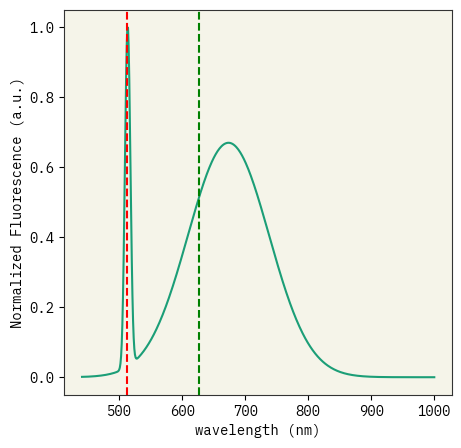

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
1            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
1             1.75      0.006         7.8             5            2  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
1  0.362976  0.243591  0.000377  0.243198   

                                      Fl_Wavelengths  \
1  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
1  [0.05875342277612322, 0.061531410939200504, 0....   

                                   Fluorescence_norm  \
1  [2.1105257504146727e-05, 2.2103159460405937e-0...   

                                     Abs_Wavelengths  \
1  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
1  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


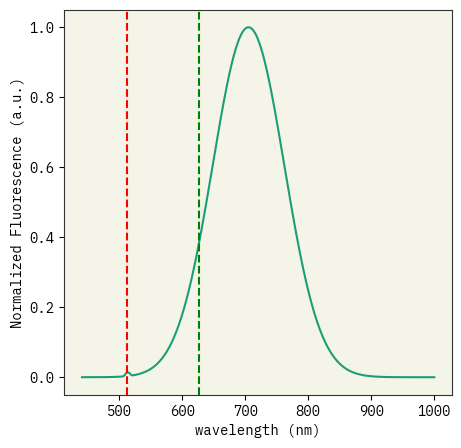

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
2            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
2             1.75      0.006         7.8             5            2  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
2  0.362976  0.245067  0.000693  0.244346   

                                      Fl_Wavelengths  \
2  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
2  [0.16726935860227754, 0.17430678840129743, 0.1...   

                                   Fluorescence_norm  \
2  [5.7619824046038625e-05, 6.00440305483188e-05,...   

                                     Abs_Wavelengths  \
2  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
2  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


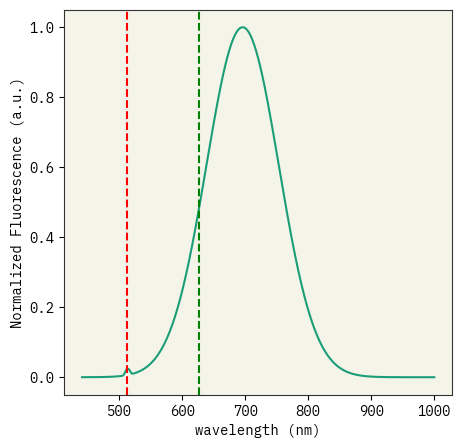

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
3            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
3             1.75      0.006         7.8             5            2  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
3  0.362976  0.089776   0.00015  0.089622   

                                      Fl_Wavelengths  \
3  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
3  [0.0059593828942451415, 0.006355854469534446, ...   

                                   Fluorescence_norm  \
3  [5.1227292593135085e-06, 5.463539134306094e-06...   

                                     Abs_Wavelengths  \
3  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
3  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


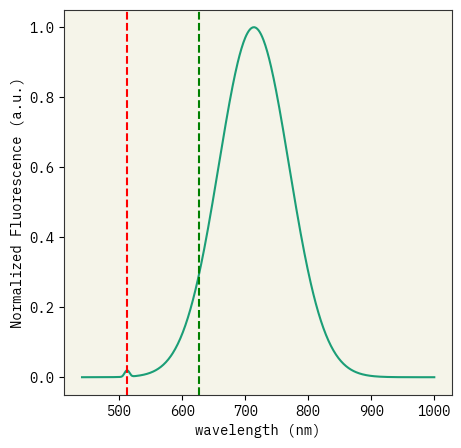

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
4            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
4             1.75     0.0007         3.5            20            8  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
4  0.362976  0.276434   0.27384   0.00184   

                                      Fl_Wavelengths  \
4  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
4  [1.9618019074826825e-16, 6.15887754421026e-16,...   

                                   Fluorescence_norm  \
4  [5.600871903107058e-22, 1.7583367648116504e-21...   

                                     Abs_Wavelengths  \
4  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
4  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


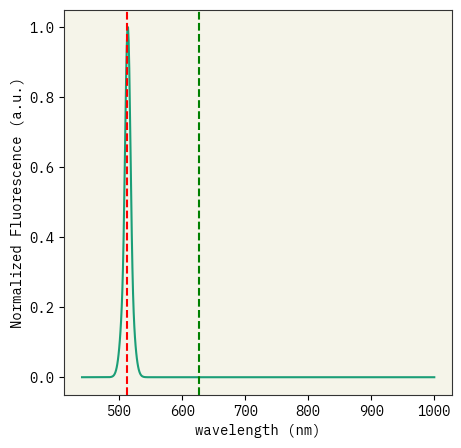

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
5            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
5             1.75     0.0007         3.5            20            8  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
5  0.362976  0.238726  0.133452  0.104491   

                                      Fl_Wavelengths  \
5  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
5  [843.7732037306504, 854.099869701119, 864.5560...   

                                   Fluorescence_norm  \
5  [0.004671259087753779, 0.004728429109327666, 0...   

                                     Abs_Wavelengths  \
5  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
5  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


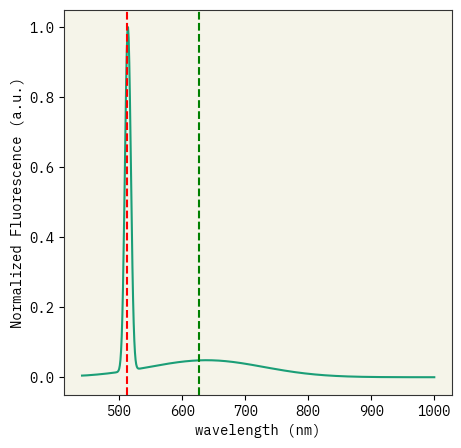

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
6            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
6             1.75     0.0007         3.5            20            8  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
6  0.362976  0.198304  0.086333  0.111654   

                                      Fl_Wavelengths  \
6  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
6  [232.80845482565977, 237.04106166472914, 241.3...   

                                   Fluorescence_norm  \
6  [0.0019422595965871783, 0.0019775711202082566,...   

                                     Abs_Wavelengths  \
6  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
6  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


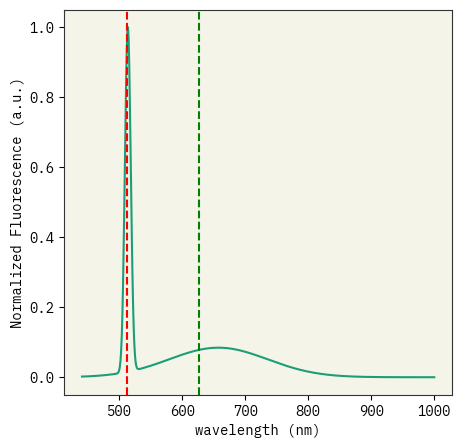

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
7            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
7             1.75     0.0007         3.5            20            8  ...   

     Pre-QY       QY  QY_peak1  QY_peak2  \
7  0.362976  0.20888  0.107651  0.100773   

                                      Fl_Wavelengths  \
7  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
7  [405.8360022969409, 411.98135013926156, 418.22...   

                                   Fluorescence_norm  \
7  [0.0027732142920508652, 0.0028152075266813363,...   

                                     Abs_Wavelengths  \
7  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
7  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                     A

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


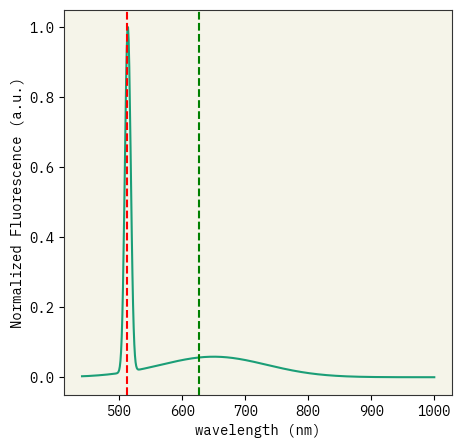

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
8            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
8             1.75     0.0007         3.5            20            8  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
8  0.362976  0.169517  0.069364  0.099923   

                                      Fl_Wavelengths  \
8  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
8  [123.25434046634516, 125.68524703701667, 128.1...   

                                   Fluorescence_norm  \
8  [0.0015497997462713734, 0.0015803659589676705,...   

                                     Abs_Wavelengths  \
8  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
8  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


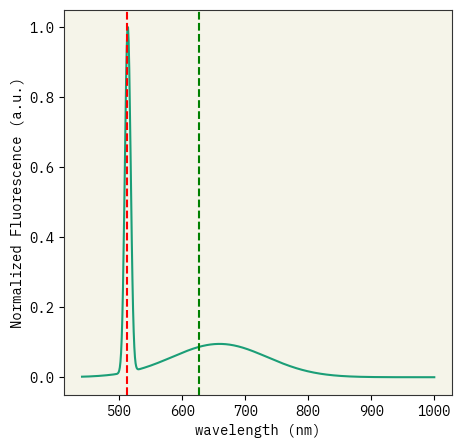

   Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
9            18.8           14.04  100x        0.175                0.25   

   Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
9             1.75     0.0007         3.5            20            8  ...   

     Pre-QY        QY  QY_peak1  QY_peak2  \
9  0.362976  0.166737  0.035378  0.131224   

                                      Fl_Wavelengths  \
9  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                        Fluorescence  \
9  [45.0253478923551, 46.161890465462236, 47.3324...   

                                   Fluorescence_norm  \
9  [0.0010816174157185763, 0.0011089199086102971,...   

                                     Abs_Wavelengths  \
9  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                          Absorbance  \
9  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


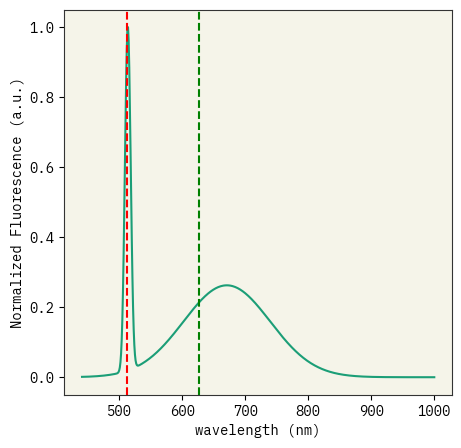

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
10            18.8           14.04  100x        0.175                0.25   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
10             1.75     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
10  0.362976  0.175461  0.062128  0.113141   

                                       Fl_Wavelengths  \
10  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
10  [84.42800212451965, 86.26927338247707, 88.1572...   

                                    Fluorescence_norm  \
10  [0.001201015419899969, 0.001227208094337106, 0...   

                                      Abs_Wavelengths  \
10  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
10  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


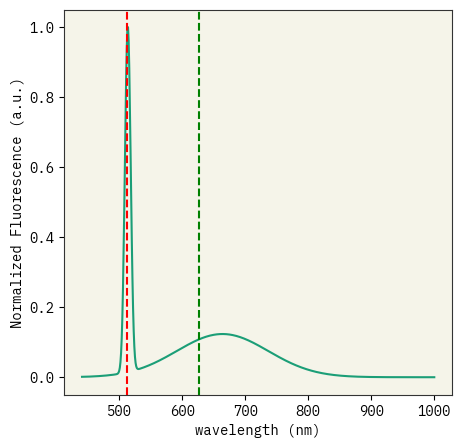

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
11            18.8           14.04  100x        0.175                0.25   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
11             1.75     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
11  0.362976  0.139167  0.030484  0.108569   

                                       Fl_Wavelengths  \
11  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
11  [42.626886734526614, 43.704349583718106, 44.81...   

                                    Fluorescence_norm  \
11  [0.0010610023256400075, 0.0010878208591140208,...   

                                      Abs_Wavelengths  \
11  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
11  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


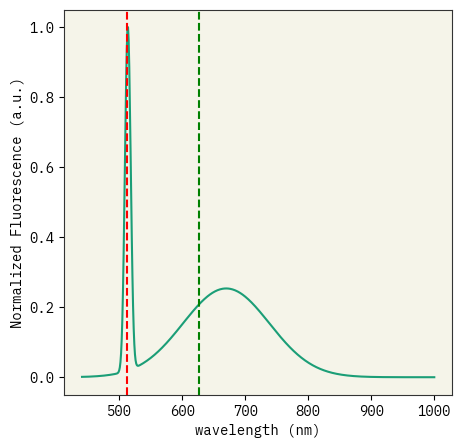

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
12            18.8           14.04  100x        0.175                0.25   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
12             1.75     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
12  0.362976  0.120512  0.019757  0.100671   

                                       Fl_Wavelengths  \
12  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
12  [29.84785867906576, 30.635525984497864, 31.447...   

                                    Fluorescence_norm  \
12  [0.0010631803229861243, 0.0010912370217664043,...   

                                      Abs_Wavelengths  \
12  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
12  [0.43802025, 0.4338412, 0.42938566666666667, 0...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


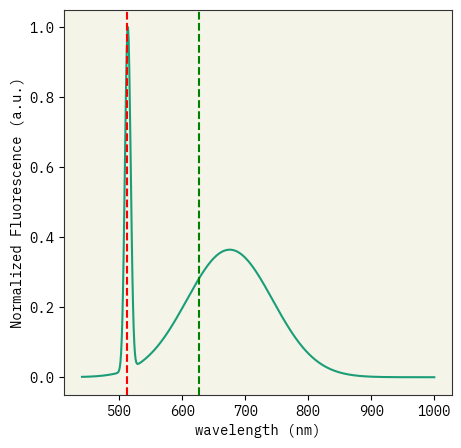

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
13            35.0            15.0  100x        0.212                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
13              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
13  0.571308  0.318119  0.176891  0.140542   

                                       Fl_Wavelengths  \
13  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
13  [207.1300976498405, 210.1238733517656, 213.164...   

                                    Fluorescence_norm  \
13  [0.002546687653398155, 0.002583496459571872, 0...   

                                      Abs_Wavelengths  \
13  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
13  [0.3873835, 0.38563000000000003, 0.38361116666...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


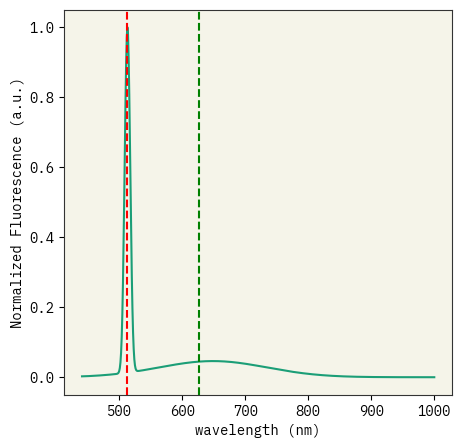

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
14            35.0            15.0  100x        0.212                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
14              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
14  0.571308  0.312704  0.176001  0.135805   

                                       Fl_Wavelengths  \
14  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
14  [312.3846276370968, 316.1837516750193, 320.030...   

                                    Fluorescence_norm  \
14  [0.003717944982848855, 0.0037631614656919985, ...   

                                      Abs_Wavelengths  \
14  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
14  [0.3873835, 0.38563000000000003, 0.38361116666...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


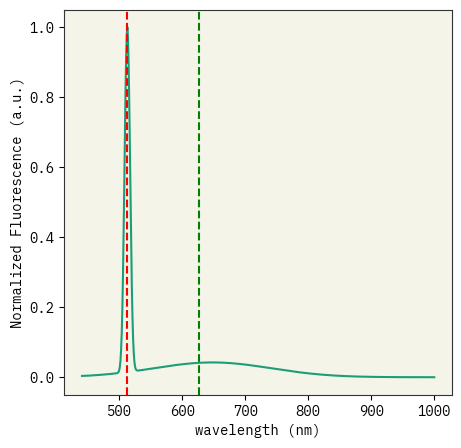

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
15            35.0            15.0  100x        0.212                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
15              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
15  0.571308  0.274497  0.097209  0.177098   

                                       Fl_Wavelengths  \
15  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
15  [25.90642910616973, 26.544968274049932, 27.202...   

                                    Fluorescence_norm  \
15  [0.0005592587117994114, 0.0005730432666293591,...   

                                      Abs_Wavelengths  \
15  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
15  [0.3873835, 0.38563000000000003, 0.38361116666...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


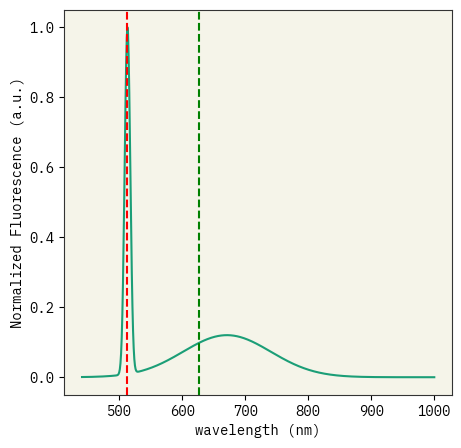

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
16            35.0            15.0  100x        0.212                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
16              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
16  0.571308  0.209649   0.05779  0.151744   

                                       Fl_Wavelengths  \
16  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
16  [14.137603726129706, 14.518881288521875, 14.91...   

                                    Fluorescence_norm  \
16  [0.0004409452910317889, 0.000452837161038173, ...   

                                      Abs_Wavelengths  \
16  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
16  [0.3873835, 0.38563000000000003, 0.38361116666...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


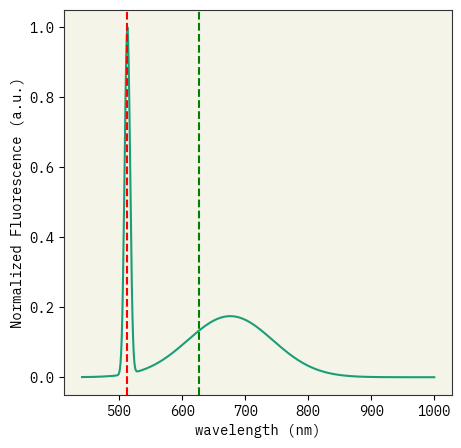

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
17            35.0            15.0  100x        0.212                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
17              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
17  0.571308  0.222023  0.038516  0.183401   

                                       Fl_Wavelengths  \
17  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
17  [8.67038884656587, 8.920890841628996, 9.180063...   

                                    Fluorescence_norm  \
17  [0.0004971650455517746, 0.0005115289729361499,...   

                                      Abs_Wavelengths  \
17  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
17  [0.3873835, 0.38563000000000003, 0.38361116666...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


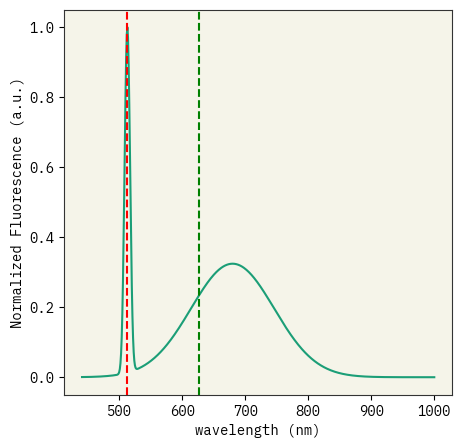

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
18           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
18              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
18  0.371625  0.346038  0.162245  0.183297   

                                       Fl_Wavelengths  \
18  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
18  [77.9258209279122, 79.33390320902437, 80.77077...   

                                    Fluorescence_norm  \
18  [0.0015635211372216223, 0.0015917732157143564,...   

                                      Abs_Wavelengths  \
18  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
18  [0.237335, 0.23614319999999997, 0.234686999999...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


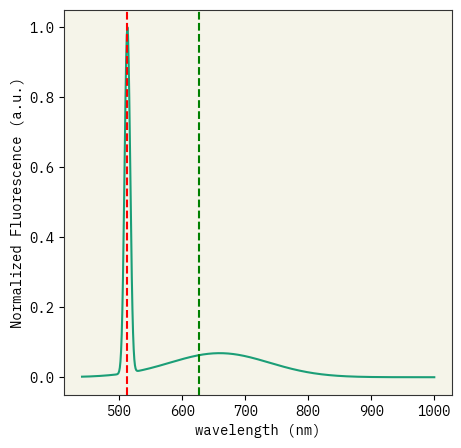

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
19           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
19              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
19  0.371625  0.214765  0.076668  0.137983   

                                       Fl_Wavelengths  \
19  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
19  [7.016106728009413, 7.223332516874214, 7.43789...   

                                    Fluorescence_norm  \
19  [0.00026721139824754204, 0.0002751036802412659...   

                                      Abs_Wavelengths  \
19  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
19  [0.237335, 0.23614319999999997, 0.234686999999...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


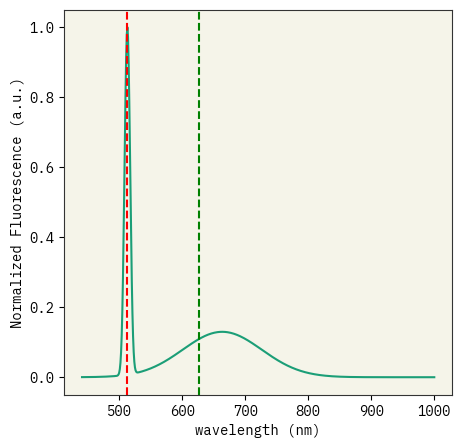

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
20           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
20              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
20  0.371625  0.236007  0.040295   0.19562   

                                       Fl_Wavelengths  \
20  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
20  [3.570959511312541, 3.684684506573321, 3.80278...   

                                    Fluorescence_norm  \
20  [0.00030579991177124476, 0.0003155387770277004...   

                                      Abs_Wavelengths  \
20  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
20  [0.237335, 0.23614319999999997, 0.234686999999...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


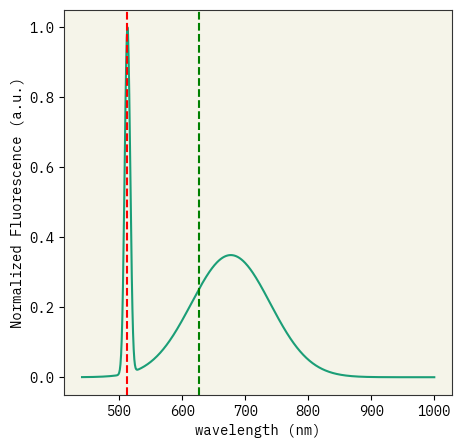

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
21           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
21              3.5     0.0007         3.5            20            8  ...   

      Pre-QY       QY  QY_peak1  QY_peak2  \
21  0.371625  0.18382  0.002101  0.181695   

                                       Fl_Wavelengths  \
21  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
21  [0.26920614343673344, 0.28051792344431464, 0.2...   

                                    Fluorescence_norm  \
21  [6.776537878361609e-05, 7.061281401352875e-05,...   

                                      Abs_Wavelengths  \
21  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
21  [0.237335, 0.23614319999999997, 0.234686999999...   

                      

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


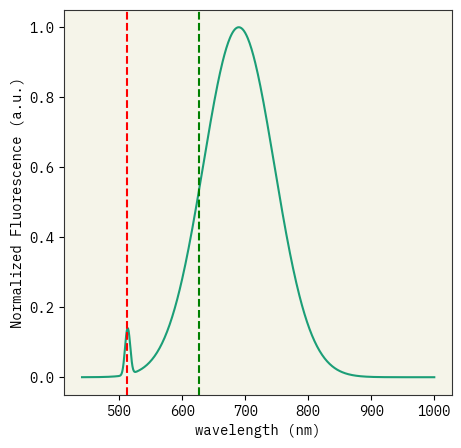

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
22           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
22              3.5      0.006        14.0            10            4  ...   

      Pre-QY       QY  QY_peak1  QY_peak2  \
22  0.420062  0.43601  0.099896  0.335841   

                                       Fl_Wavelengths  \
22  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
22  [20.0631450734778, 20.60898743357346, 21.17254...   

                                    Fluorescence_norm  \
22  [0.0006194652246048316, 0.0006363185324465058,...   

                                      Abs_Wavelengths  \
22  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
22  [0.24762975, 0.24626640000000002, 0.2448663333...   

                      

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


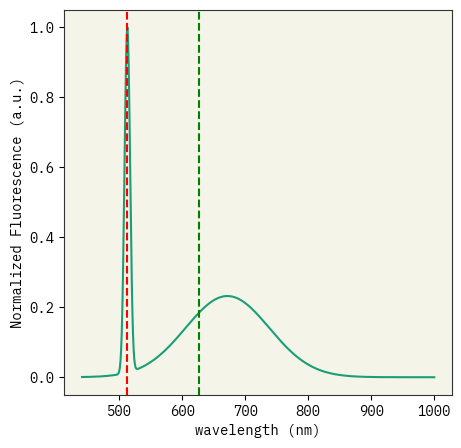

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
23           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
23              3.5      0.006        14.0            10            4  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
23  0.420062  0.407964  0.030301  0.377498   

                                       Fl_Wavelengths  \
23  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
23  [6.888005132820488, 7.111916241188642, 7.34463...   

                                    Fluorescence_norm  \
23  [0.0007159000447175083, 0.000739172090745713, ...   

                                      Abs_Wavelengths  \
23  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
23  [0.24762975, 0.24626640000000002, 0.2448663333...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


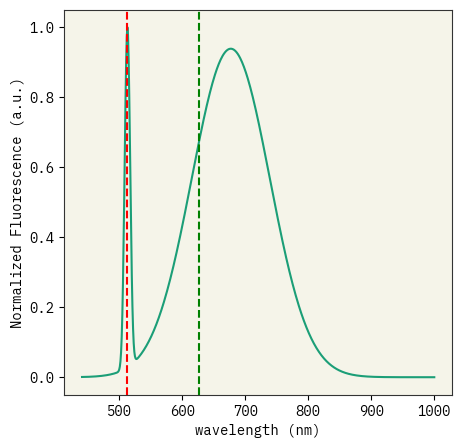

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
24           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
24              3.5      0.006        14.0            10            4  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
24  0.420062  0.306997   0.00461  0.302294   

                                       Fl_Wavelengths  \
24  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
24  [3.912605944113564, 4.048006251508225, 4.18909...   

                                    Fluorescence_norm  \
24  [0.000407540612068663, 0.0004216440318707323, ...   

                                      Abs_Wavelengths  \
24  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
24  [0.24762975, 0.24626640000000002, 0.2448663333...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


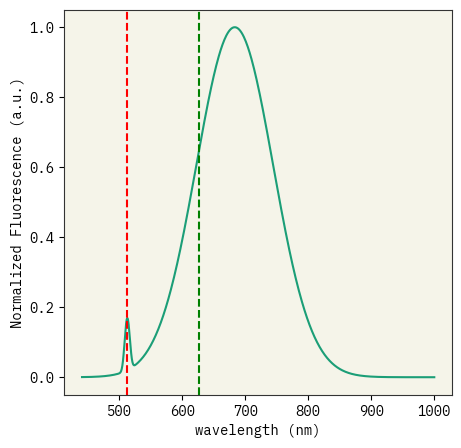

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
25           31.63            13.8  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
25              3.5      0.006        14.0            10            4  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
25  0.420062  0.198012  0.000422  0.197582   

                                       Fl_Wavelengths  \
25  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
25  [0.03009374813451522, 0.031874784674749586, 0....   

                                    Fluorescence_norm  \
25  [5.94633747468256e-06, 6.298259218548953e-06, ...   

                                      Abs_Wavelengths  \
25  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
25  [0.24762975, 0.24626640000000002, 0.2448663333...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


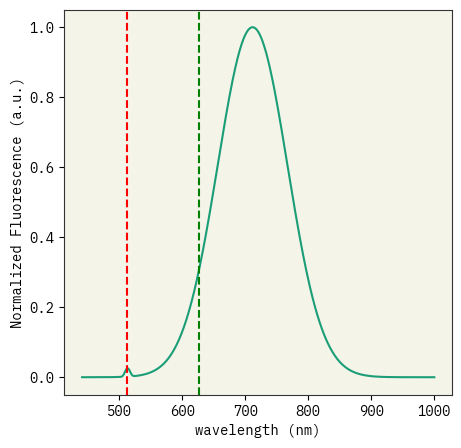

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
26           39.16            6.34  100x         0.42                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
26              3.5      0.006        14.0            10            4  ...   

    Pre-QY        QY  QY_peak1  QY_peak2  \
26    -1.0  0.900391  0.781599  0.113992   

                                       Fl_Wavelengths  \
26  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
26  [1298.5561008146108, 1311.420357405029, 1324.3...   

                                    Fluorescence_norm  \
26  [0.006104635263188995, 0.006165111352260014, 0...   

                                      Abs_Wavelengths  \
26  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
26  [0.09221025, 0.0920118, 0.09164733333333334, 0...   

                        

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


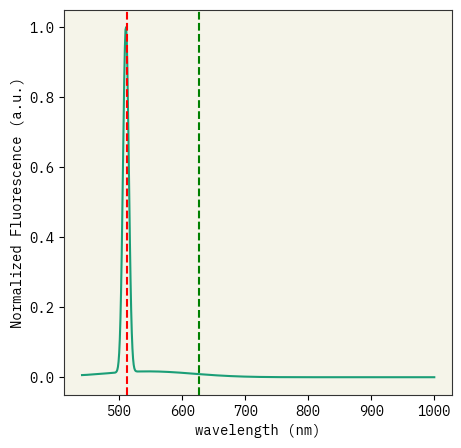

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
27           39.16            6.34  100x         0.42                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
27              3.5      0.006        14.0            10            4  ...   

    Pre-QY        QY  QY_peak1  QY_peak2  \
27    -1.0  0.457926  0.015232  0.442577   

                                       Fl_Wavelengths  \
27  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
27  [1.7068884466371288, 1.7754802116322383, 1.847...   

                                    Fluorescence_norm  \
27  [0.0001768339146464667, 0.00018394003241326785...   

                                      Abs_Wavelengths  \
27  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
27  [0.08318149999999999, 0.083019, 0.082645833333...   

                        

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


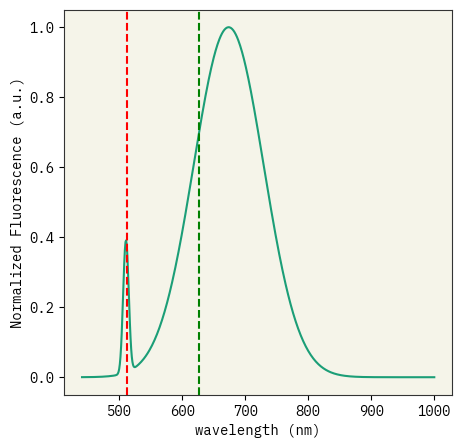

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
28           36.27            6.52  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
28              3.5     0.0007         3.5            20            8  ...   

      Pre-QY        QY  QY_peak1  QY_peak2  \
28  0.741048  0.489114  0.302948  0.185967   

                                       Fl_Wavelengths  \
28  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
28  [8.596467545701113, 8.877650338902003, 9.16984...   

                                    Fluorescence_norm  \
28  [9.851666936749886e-05, 0.00010173906183537418...   

                                      Abs_Wavelengths  \
28  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
28  [0.24550525, 0.2444272, 0.24288250000000003, 0...   

                    

/var/folders/cm/sn2bpgln3zdc0lh8s2384hr40000gn/T/ipykernel_87780/784225269.py:16: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(wl, fl, label=name)


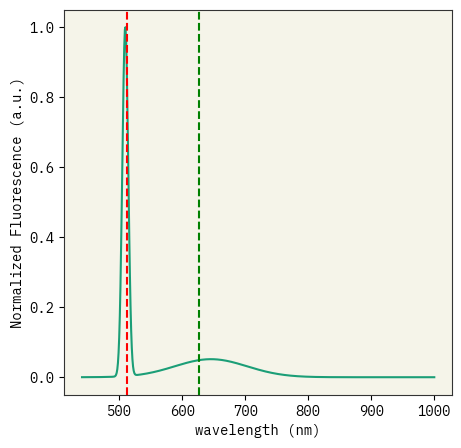

    Dimension1(nm)  Dimension2(nm)    OD  Dilution(%)  Nano_stock_vol(mL)  \
32           36.27            6.52  100x         0.12                 0.5   

    Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  ...  \
32              3.5     0.0007         3.5            20            8  ...   

      Pre-QY       QY  QY_peak1  QY_peak2  \
32  0.741048  0.37916  0.378145  0.000696   

                                       Fl_Wavelengths  \
32  [441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...   

                                         Fluorescence  \
32  [1.0047374225749333e-13, 2.699085957609317e-13...   

                                    Fluorescence_norm  \
32  [8.604189059994123e-19, 2.3113945341986944e-18...   

                                      Abs_Wavelengths  \
32  [300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...   

                                           Absorbance  \
32  [0.24550525, 0.2444272, 0.24288250000000003, 0...   

                      

KeyError: 29

In [25]:
#read data from processed_wobaselinev4.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
df = pd.read_csv('Data/processed_datawobaselinev9.csv')
#group by experiment
grouped = list(df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']))
#plot the wavelength vs normalized fluorescence intensity for each experiment
for i, (name, group) in enumerate(grouped):
    print(group)
    wl = ast.literal_eval(group['Fl_Wavelengths'][i])
    fl = ast.literal_eval(group['Fluorescence_norm'][i])
    #increase the size
    plt.figure(figsize=(5,5))
    plt.plot(wl, fl, label=name)
    plt.xlabel('wavelength (nm)')
    plt.ylabel('Normalized Fluorescence (a.u.)')
    #make the Peak1,Peak2 be vertical lines in the plot
    plt.axvline(x=513.1, color='r', linestyle='--', label='Peak1')
    plt.axvline(x=626, color='g', linestyle='--', label='Peak2')
    plt.show()
    
    # for exp, temp,doping,temp in name:
    #     plt.plot(group['Fl_Wavelengths'], group['Fluorescence_norm'], label=name)
    #     plt.plot(group['Fl_Wavelengths'], group['Fluorescence_norm'], label=name)
